# 101 阿尔法公式

基于 [101 Formulaic Alphas](https://arxiv.org/pdf/1601.00991.pdf)，Zura Kakushadze，arxiv，2015

## 导入和设置

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from talib import WMA

In [3]:
idx= pd.IndexSlice
sns.set_style('whitegrid')

>“阿尔法是数学表达式、计算机源代码和配置参数的组合
> 可以结合历史数据来预测各种未来的走势
> 金融工具”

[寻找阿尔法：构建交易策略的定量方法](https://books.google.com/books?hl=en&lr=&id=ntuuDwAAQBAJ&oi=fnd&pg=PR11&dq=Finding+Alphas:+A+Quantitative+Approach+to+建筑+交易+策略&ots=nQrqbJlQu1&sig=FWfLI0_AIJWiNJ3D6tE0twHjj5I#v=onepage&q=Finding%20Alphas%3A%20A%20Quantitative%20Approach%20to%20Building%20Trading%20Strategies&f=false), Igor Tulchinsky , 2019

## 函数

下面定义 101 个公式 alpha 的表达式包含用于时间序列和横截面计算的函数。

### 横截面

| 函数| 定义 |
|:---|:---|
|rank(x) | 横截面排名|
|scale(x, a) | 重新缩放 x 使得 sum(abs(x)) = a（默认值为 a = 1）|
|indneutralize(x, g) | x 在 g 组（子行业、行业等）内受到横截面贬低 |


In [4]:
def rank(df):
    """Return the cross-sectional percentile rank

     Args:
         :param df: tickers in columns, sorted dates in rows.

     Returns:
         pd.DataFrame: the ranked values
     """
    return df.rank(axis=1, pct=True)

In [5]:
def scale(df):
    """
    Scaling time serie.
    :param df: a pandas DataFrame.
    :param k: scaling factor.
    :return: a pandas DataFrame rescaled df such that sum(abs(df)) = k
    """
    return df.div(df.abs().sum(axis=1), axis=0)

### 运算

- abs(x)、log(x)、sign(x)、power(x, a) = 标准定义
- “+”, “-”, “*”, “/”, “>”, “<”, “==”, “||”, “x ? y : z” 和Python定义相同

In [6]:
def log(df):
    return np.log1p(df)

In [7]:
def sign(df):
    return np.sign(df)

In [8]:
def power(df, exp):
    return df.pow(exp)

### 时间序列

| 函数| 定义 |
|:---|:---|
|ts_{O}(x, d) | 算子 O 应用于过去 d 天的时间序列；非整数天数 d 转换为下限(d)|
|ts_lag(x, d) | x d 天前的值|
|ts_delta(x, d) | 今天 x 的值与 d 天前的值之差|
|ts_weighted_mean(x, d) | 过去 d 天的加权移动平均值，权重线性衰减 d, d – 1, …, 1（重新调整后总和为 1）|
| ts_sum(x, d) | 过去 d 天的滚动总和|
| ts_product(x, d) | 过去 d 天的滚动乘积|
| ts_stddev(x, d) | 过去 d 天的移动标准差| 
|ts_rank(x, d) | 过去d天内的排名|
|ts_min(x, d) | 过去 d 天的滚动最小值 \[别名: min(x, d)\]|
|ts_max(x, d) | 过去 d 天的滚动最大值\[别名：max(x, d)\]|
|ts_argmax(x, d) | ts_max(x, d) 的日期|
|ts_argmin(x, d) | ts_min(x, d) 的日期|
|ts_correlation(x, y, d) | 过去 d 天的 x 和 y 的相关性|
|ts_covariance(x, y, d) | 过去 d 天的 x 和 y 的协方差|

#### Pandas 实现

In [9]:
def ts_lag(df: pd.DataFrame, t: int = 1) -> pd.DataFrame:
    """Return the lagged values t periods ago.

    Args:
        :param df: tickers in columns, sorted dates in rows.
        :param t: lag

    Returns:
        pd.DataFrame: the lagged values
    """
    return df.shift(t)

In [10]:
def ts_delta(df, period=1):
    """
    Wrapper function to estimate difference.
    :param df: a pandas DataFrame.
    :param period: the difference grade.
    :return: a pandas DataFrame with today’s value minus the value 'period' days ago.
    """
    return df.diff(period)

In [11]:
def ts_sum(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    """Computes the rolling ts_sum for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the ts_sum over the last 'window' days.
    """
    return df.rolling(window).sum()

In [12]:
def ts_mean(df, window=10):
    """Computes the rolling mean for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the mean over the last 'window' days.
    """
    return df.rolling(window).mean()

In [13]:
def ts_weighted_mean(df, period=10):
    """
    Linear weighted moving average implementation.
    :param df: a pandas DataFrame.
    :param period: the LWMA period
    :return: a pandas DataFrame with the LWMA.
    """
    return (df.apply(lambda x: WMA(x, timeperiod=period)))

In [14]:
def ts_std(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return (df
            .rolling(window)
            .std())

In [15]:
def ts_rank(df, window=10):
    """
    Wrapper function to estimate rolling rank.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series rank over the past window days.
    """
    return (df
            .rolling(window)
            .apply(lambda x: x.rank().iloc[-1]))

In [16]:
def ts_product(df, window=10):
    """
    Wrapper function to estimate rolling ts_product.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series ts_product over the past 'window' days.
    """
    return (df
            .rolling(window)
            .apply(np.prod))

In [17]:
def ts_min(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).min()

In [18]:
def ts_max(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series max over the past 'window' days.
    """
    return df.rolling(window).max()

In [19]:
def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax).add(1)

In [20]:
def ts_argmin(df, window=10):
    """
    Wrapper function to estimate which day ts_min(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return (df.rolling(window)
            .apply(np.argmin)
            .add(1))

In [21]:
def ts_corr(x, y, window=10):
    """
    Wrapper function to estimate rolling correlations.
    :param x, y: pandas DataFrames.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).corr(y)

In [22]:
def ts_cov(x, y, window=10):
    """
    Wrapper function to estimate rolling covariance.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).cov(y)

## 加载数据

### 50 只交易量最大的股票

In [24]:
ohlcv = ['open', 'high', 'low', 'close', 'volume']
data = (pd.read_hdf('cn_data.h5', 'data/top50')
        .loc[:, ohlcv + ['ret_01', 'sector', 'ret_fwd']]
        .rename(columns={'ret_01': 'returns'})
        .sort_index())

In [25]:
adv20 = data.groupby('code').rolling(20).volume.mean().reset_index(0, drop=True)

In [26]:
data = data.assign(adv20=adv20)

In [27]:
data = data.join(data.groupby('date')[ohlcv].rank(axis=1, pct=True), rsuffix='_rank')

In [28]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         72550 non-null  float64
 1   high         72550 non-null  float64
 2   low          72550 non-null  float64
 3   close        72550 non-null  float64
 4   volume       72550 non-null  float64
 5   returns      72500 non-null  float64
 6   sector       72550 non-null  int64  
 7   ret_fwd      72550 non-null  float64
 8   adv20        0 non-null      float64
 9   open_rank    72550 non-null  float64
 10  high_rank    72550 non-null  float64
 11  low_rank     72550 non-null  float64
 12  close_rank   72550 non-null  float64
 13  volume_rank  72550 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 10.1+ MB


In [30]:
data.tail()

open    high     low   close      volume   returns  \
code      date                                                               
sz.300274 2023-06-14  104.88  106.28  102.50  103.17  18273918.0 -0.012822   
          2023-06-15  103.38  112.00  102.12  110.77  38679861.0  0.073665   
          2023-06-16  111.30  114.98  110.00  114.09  31711869.0  0.029972   
          2023-06-19  113.00  115.87  112.50  113.95  16183960.0 -0.001227   
          2023-06-20  113.60  115.72  112.64  113.56  14168712.0 -0.003423   

                      sector   ret_fwd  adv20  open_rank  high_rank  low_rank  \
code      date                                                                  
sz.300274 2023-06-14      11  0.073665    NaN       0.82       0.82      0.82   
          2023-06-15      11  0.029972    NaN       0.82       0.82      0.82   
          2023-06-16      11 -0.001227    NaN       0.84       0.84      0.84   
          2023-06-19      11 -0.003423    NaN       0.84       0.84      0.84   
          2023-06-20      11 -0.003610    NaN       0.84       0.84      0.84   

                      close_rank  volume_rank  
code      date                                 
sz.300274 2023-06-14        0.82         0.32  
          2023-06-15        0.82         0.48  
          2023-06-16        0.84         0.42  
          2023-06-19        0.82         0.24  
          2023-06-20        0.84         0.28

In [31]:
# data.to_hdf('factors.h5', 'data')

### 输入数据

|变量|说明|
|:---|:---|
|returns | 每日收盘收益|
|open, close, high, low, volume | 每日价格和数量数据的标准定义|
|vwap | 每日成交量加权平均价格|
|cap | 市值|
|adv{d} | 过去 d 天的平均每日成交量|
|IndClass | indneutralize(x, IndClass.level) 中二元行业分类（例如 GICS、BICS、NAICS、SIC 等）的通用占位符，其中 level = 部门、行业、子行业等。同一 alpha 中不需要多个 IndClass对应同一行业分类。|

In [32]:
o = data.open.unstack('code')
h = data.high.unstack('code')
l = data.low.unstack('code')
c = data.close.unstack('code')
v = data.volume.unstack('code')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.returns.unstack('code')

## 评估 Alpha

In [33]:
alphas = data[['returns', 'ret_fwd']].copy()
mi,ic = {}, {}

In [63]:
def get_mutual_info_score(returns, alpha, n=10000):
    df = pd.DataFrame({'y': returns, 'alpha': alpha}).dropna().sample(n=n)
    return mutual_info_regression(y=df.y, X=df[['alpha']])[0]

## Alpha 001

```
rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5))
```

In [35]:
def alpha001(c, r):
    """(rank(ts_argmax(power(((returns < 0)
        ? ts_std(returns, 20)
        : close), 2.), 5)) -0.5)"""
    c[r < 0] = ts_std(r, 20)
    return (rank(ts_argmax(power(c, 2), 5)).mul(-.5)
            .stack().swaplevel())

In [36]:
alpha = 1

In [37]:
%%time
alphas[f'{alpha:03}'] = alpha001(c, r)

CPU times: total: 4.34 s
Wall time: 9.34 s


In [38]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  72500 non-null  float64
 1   ret_fwd  72550 non-null  float64
 2   001      71459 non-null  float64
dtypes: float64(3)
memory usage: 4.0+ MB


In [39]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

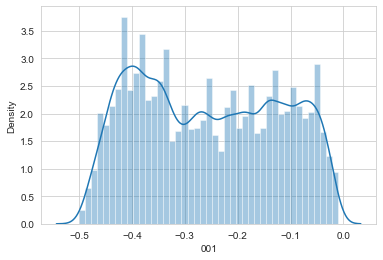

In [40]:
sns.distplot(alphas[f'{alpha:03}']);

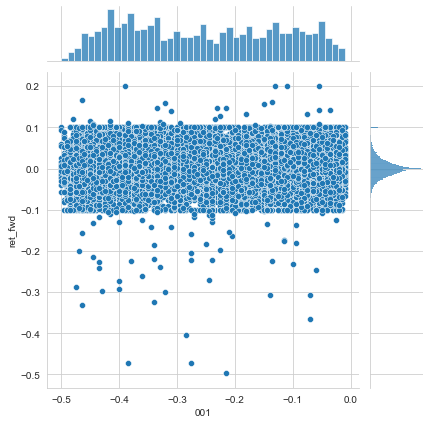

In [41]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [64]:
mi[1] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[1]

0.007558375478113

## Alpha 002

```
correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
```

In [46]:
def alpha002(o, c, v):
    """(-1 * ts_corr(rank(ts_delta(log(volume), 2)), rank(((close - open) / open)), 6))"""
    s1 = rank(ts_delta(log(v), 2))
    s2 = rank((c / o) - 1)
    alpha = -ts_corr(s1, s2, 6)
    return alpha.stack('code').swaplevel().replace([-np.inf, np.inf], np.nan)

In [47]:
alpha = 2

In [48]:
%%time
alphas[f'{alpha:03}'] = alpha002(o, c, v)

CPU times: total: 188 ms
Wall time: 313 ms


In [50]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

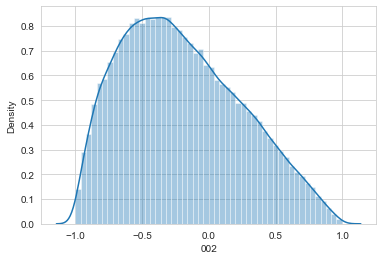

In [51]:
sns.distplot(alphas[f'{alpha:03}']);

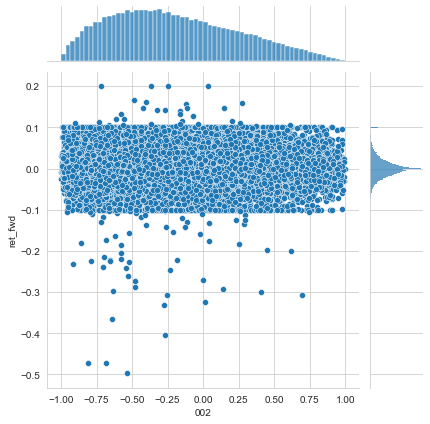

In [52]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [56]:
alphas

returns   ret_fwd    001       002
code      date                                           
sh.600030 2017-07-04       NaN  0.008368    NaN       NaN
          2017-07-05  0.008368 -0.008299    NaN       NaN
          2017-07-06 -0.008299  0.013150    NaN       NaN
          2017-07-07  0.013150  0.003540    NaN       NaN
          2017-07-10  0.003540  0.008818    NaN       NaN
...                        ...       ...    ...       ...
sz.300274 2023-06-14 -0.012822  0.073665 -0.195 -0.101784
          2023-06-15  0.073665  0.029972 -0.340 -0.369614
          2023-06-16  0.029972 -0.001227 -0.335 -0.451385
          2023-06-19 -0.001227 -0.003423 -0.255 -0.789921
          2023-06-20 -0.003423 -0.003610 -0.220 -0.789175

[72550 rows x 4 columns]

In [55]:
f'{alpha:03}'

'002'

In [65]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[2]

0.004916587992787491

## Alpha 003

```
(-1 * correlation(rank(open), rank(volume), 10))
```

In [66]:
def alpha003(o, v):
    """(-1 * ts_corr(rank(open), rank(volume), 10))"""

    return (-ts_corr(rank(o), rank(v), 10)
            .stack('code')
            .swaplevel()
            .replace([-np.inf, np.inf], np.nan))

In [67]:
alpha = 3

In [68]:
%%time
alphas[f'{alpha:03}'] = alpha003(o, v)

CPU times: total: 250 ms
Wall time: 535 ms


In [69]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

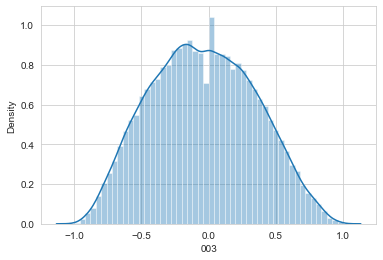

In [70]:
sns.distplot(alphas[f'{alpha:03}'].clip(lower=-1));

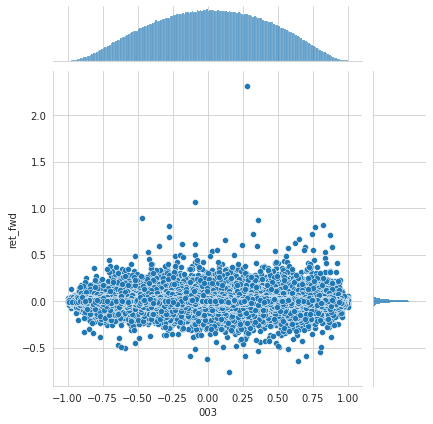

In [52]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [71]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 004

```
(-1 * Ts_Rank(rank(low), 9))
```

In [73]:
def alpha004(l):
    """(-1 * Ts_Rank(rank(low), 9))"""
    return (-ts_rank(rank(l), 9)
            .stack('code')
            .swaplevel())

In [74]:
alpha = 4

In [75]:
%%time
alphas[f'{alpha:03}'] = alpha004(l)

CPU times: total: 5.95 s
Wall time: 14.7 s


In [76]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

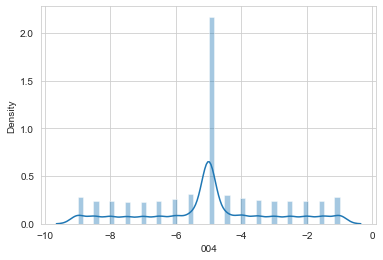

In [77]:
sns.distplot(alphas[f'{alpha:03}']);

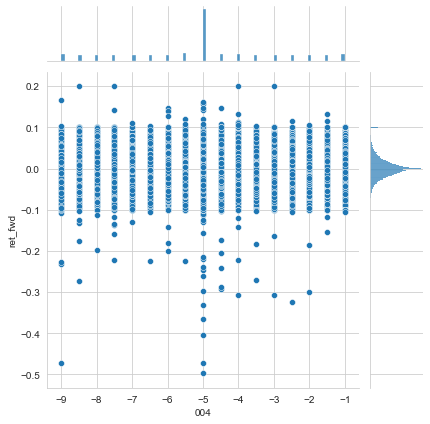

In [78]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [79]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 005

Very roughly approximating wvap as average of OHLC.

```
(rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
```

In [83]:
def alpha005(o, vwap, c):
    """(rank((open - ts_mean(vwap, 10))) * (-1 * abs(rank((close - vwap)))))"""
    return (rank(o.sub(ts_mean(vwap, 10)))
            .mul(rank(c.sub(vwap)).mul(-1).abs())
            .stack('code')
            .swaplevel())

In [84]:
alpha = 5

In [85]:
%%time
alphas[f'{alpha:03}'] = alpha005(o, vwap, c)

CPU times: total: 156 ms
Wall time: 369 ms


In [86]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

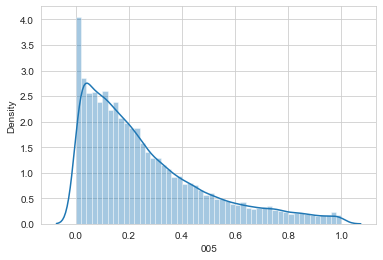

In [87]:
sns.distplot(alphas[f'{alpha:03}']);

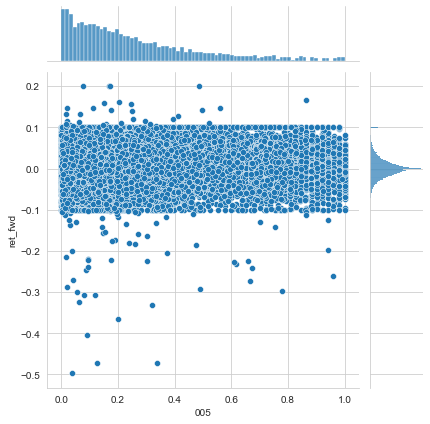

In [88]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [89]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0019678135044491896

## Alpha 006

```
-ts_corr(open, volume, 10)
```

In [91]:
def alpha006(o, v):
    """(-ts_corr(open, volume, 10))"""
    return (-ts_corr(o, v, 10)
            .stack('code')
            .swaplevel())

In [92]:
alpha = 6

In [93]:
%%time
alphas[f'{alpha:03}'] = alpha006(o, v)

CPU times: total: 141 ms
Wall time: 297 ms


In [95]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

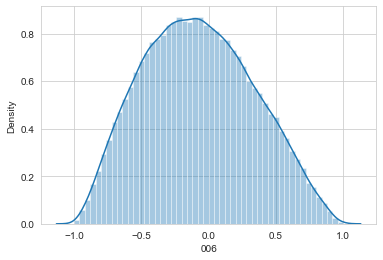

In [96]:
sns.distplot(alphas[f'{alpha:03}']);

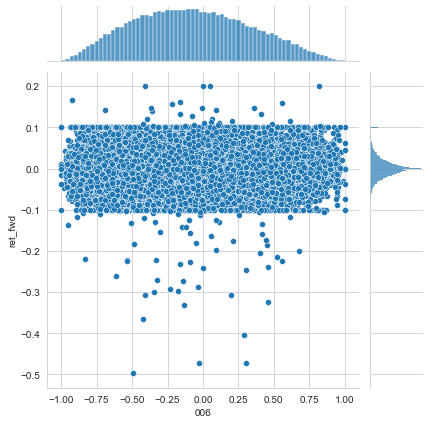

In [97]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [98]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [99]:
mi[alpha]

0.010256577624664587

## Alpha 007

```
(adv20 < volume) 
? ((-1 * ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) 
: -1
```

In [100]:
def alpha007(c, v, adv20):
    """(adv20 < volume) 
        ? ((-ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) 
        : -1
    """
    
    delta7 = ts_delta(c, 7)
    return (-ts_rank(abs(delta7), 60)
            .mul(sign(delta7))
            .where(adv20<v, -1)
            .stack('code')
            .swaplevel())

In [101]:
alpha = 7

In [102]:
%%time
alphas[f'{alpha:03}'] = alpha007(c, v, adv20)

CPU times: total: 5.36 s
Wall time: 14.1 s


In [103]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

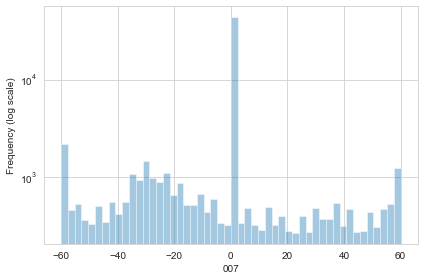

In [104]:
ax = sns.distplot(alphas[f'{alpha:03}'], kde=False)
ax.set_yscale('log')
ax.set_ylabel('Frequency (log scale)')
plt.tight_layout();

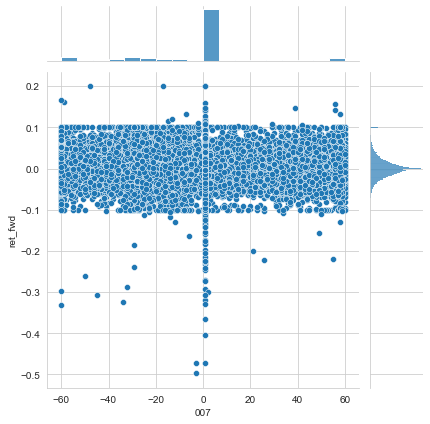

In [105]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [106]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [107]:
mi[alpha]

0.0027630118967709727

## Alpha 008

```
-rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10)))
```

In [108]:
def alpha008(o, r):
    """-rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - 
        ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10)))
    """
    return (-(rank(((ts_sum(o, 5) * ts_sum(r, 5)) -
                       ts_lag((ts_sum(o, 5) * ts_sum(r, 5)), 10))))
           .stack('code')
            .swaplevel())

In [109]:
alpha = 8

In [110]:
%%time
alphas[f'{alpha:03}'] = alpha008(o, r)

CPU times: total: 172 ms
Wall time: 380 ms


In [111]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

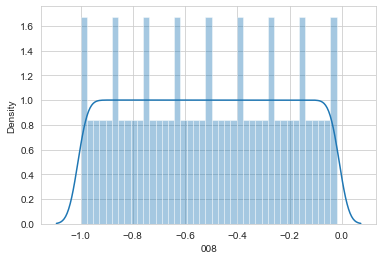

In [112]:
sns.distplot(alphas[f'{alpha:03}']);

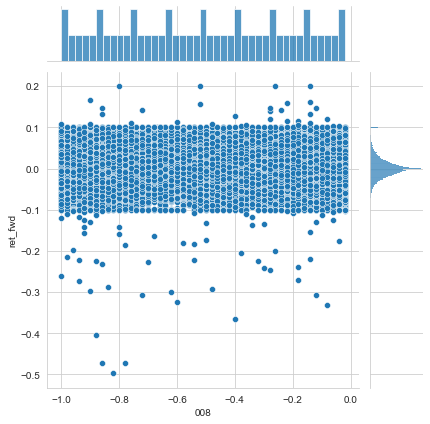

In [113]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [114]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [115]:
mi[alpha]

0.005428070856304146

## Alpha 009

```
(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 5) < 0) 
? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
```

In [116]:
def alpha009(c):
    """(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
    : ((ts_max(ts_delta(close, 1), 5) < 0) 
    ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 5) > 0,
                             close_diff.where(ts_max(close_diff, 5) < 0,
                                              -close_diff))
    return (alpha
            .stack('code')
            .swaplevel())

In [117]:
alpha = 9

In [118]:
%%time
alphas[f'{alpha:03}'] = alpha009(c)

CPU times: total: 78.1 ms
Wall time: 152 ms


In [119]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

<AxesSubplot:xlabel='009', ylabel='Density'>

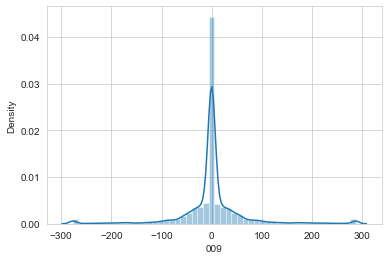

In [120]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)))

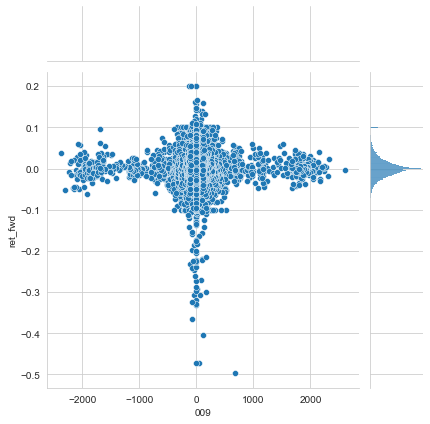

In [121]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [122]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [123]:
mi[alpha]

0.03728485458654518

In [124]:
pd.Series(mi)

1    0.007558
2    0.004917
3    0.000000
4    0.000000
5    0.001968
6    0.010257
7    0.002763
8    0.005428
9    0.037285
dtype: float64

## Alpha 010

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [125]:
def alpha010(c):
    """rank(((0 < ts_min(ts_delta(close, 1), 4)) 
        ? ts_delta(close, 1) 
        : ((ts_max(ts_delta(close, 1), 4) < 0)
            ? ts_delta(close, 1) 
            : (-1 * ts_delta(close, 1)))))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 4) > 0,
                             close_diff.where(ts_min(close_diff, 4) > 0,
                                              -close_diff))

    return (rank(alpha)
            .stack('code')
            .swaplevel())

In [126]:
alpha = 10

In [127]:
%%time
alphas[f'{alpha:03}'] = alpha010(c)

CPU times: total: 46.9 ms
Wall time: 162 ms


In [128]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

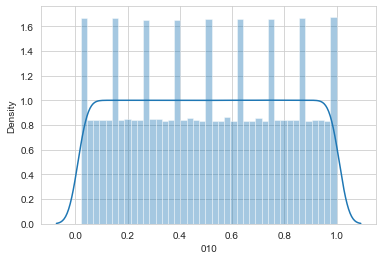

In [129]:
sns.distplot(alphas[f'{alpha:03}']);

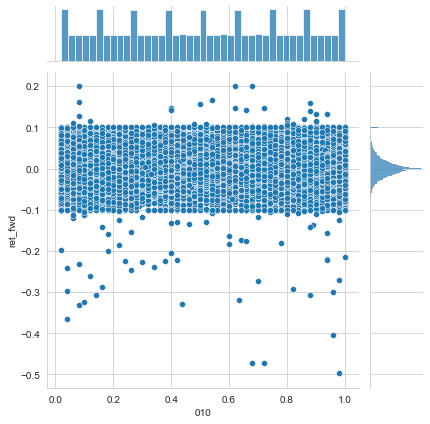

In [130]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [131]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [132]:
mi[alpha]

0.0028077618805335547

In [133]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 011

```
((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(ts_delta(volume, 3)))
```

In [134]:
def alpha011(c, vwap, v):
    """(rank(ts_max((vwap - close), 3)) + 
        rank(ts_min(vwap - close), 3)) * 
        rank(ts_delta(volume, 3))
        """
    return (rank(ts_max(vwap.sub(c), 3))
            .add(rank(ts_min(vwap.sub(c), 3)))
            .mul(rank(ts_delta(v, 3)))
            .stack('code')
            .swaplevel())

In [135]:
alpha = 11

In [136]:
%%time
alphas[f'{alpha:03}'] = alpha011(c, vwap, v)

CPU times: total: 93.8 ms
Wall time: 164 ms


In [137]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

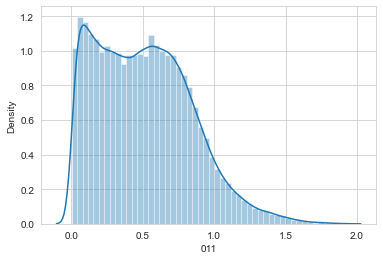

In [138]:
sns.distplot(alphas[f'{alpha:03}']);

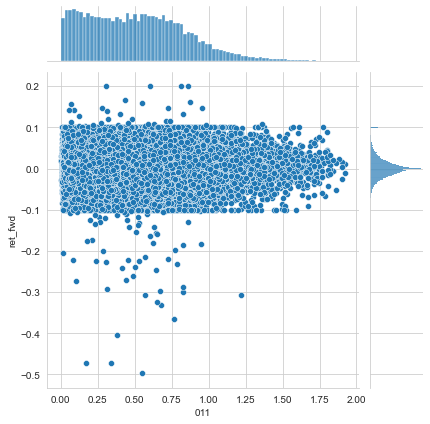

In [139]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [140]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [141]:
mi[alpha]

0

## Alpha 012

```
sign(ts_delta(volume, 1)) * -ts_delta(close, 1)
```

In [142]:
def alpha012(v, c):
    """(sign(ts_delta(volume, 1)) * 
            (-1 * ts_delta(close, 1)))
        """
    return (sign(ts_delta(v, 1)).mul(-ts_delta(c, 1))
            .stack('code')
            .swaplevel())

In [143]:
alpha = 12

In [144]:
%%time
alphas[f'{alpha:03}'] = alpha012(v, c)

CPU times: total: 62.5 ms
Wall time: 141 ms


In [145]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

<AxesSubplot:xlabel='012', ylabel='Density'>

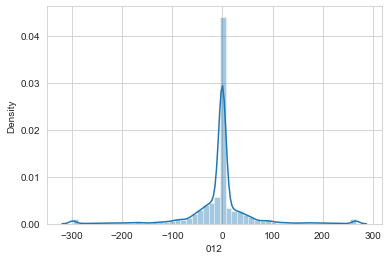

In [146]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)))

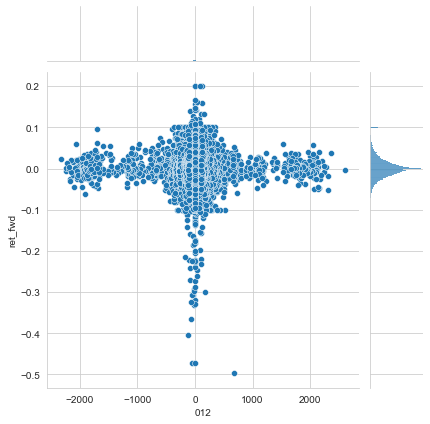

In [147]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [148]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [149]:
mi[alpha]

0.03321605246109316

## Alpha 013

```
-rank(ts_cov(rank(close), rank(volume), 5))
```

In [151]:
def alpha013(c, v):
    """-rank(ts_cov(rank(close), rank(volume), 5))"""
    return (-rank(ts_cov(rank(c), rank(v), 5))
            .stack('code')
            .swaplevel())

In [152]:
alpha = 13

In [153]:
%%time
alphas[f'{alpha:03}'] = alpha013(c, v)

CPU times: total: 234 ms
Wall time: 250 ms


In [155]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

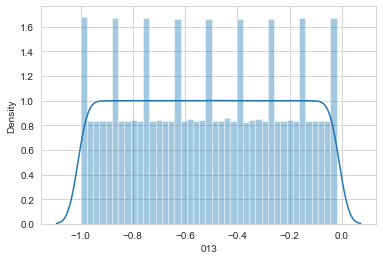

In [156]:
sns.distplot(alphas[f'{alpha:03}']);

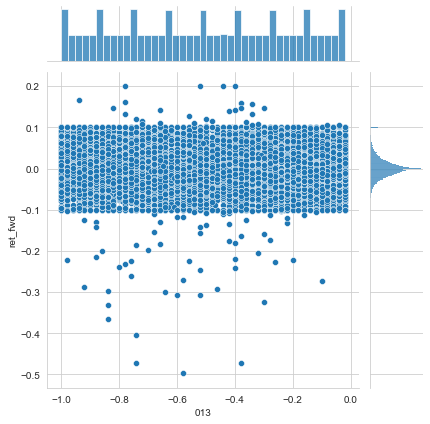

In [157]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [158]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [159]:
mi[alpha]

0

In [160]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 014

```
(-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10))
```

In [161]:
def alpha014(o, v, r):
    """
    (-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10))
    """

    alpha = -rank(ts_delta(r, 3)).mul(ts_corr(o, v, 10)
                                      .replace([-np.inf,
                                                np.inf],
                                               np.nan))
    return (alpha
            .stack('code')
            .swaplevel())

In [162]:
alpha = 14

In [163]:
%%time
alphas[f'{alpha:03}'] = alpha014(o, v, r)

CPU times: total: 172 ms
Wall time: 306 ms


In [164]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

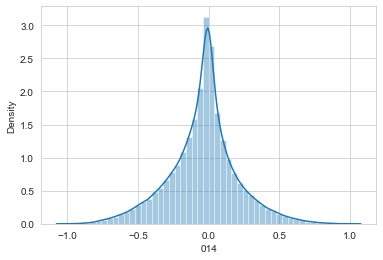

In [165]:
sns.distplot(alphas[f'{alpha:03}']);

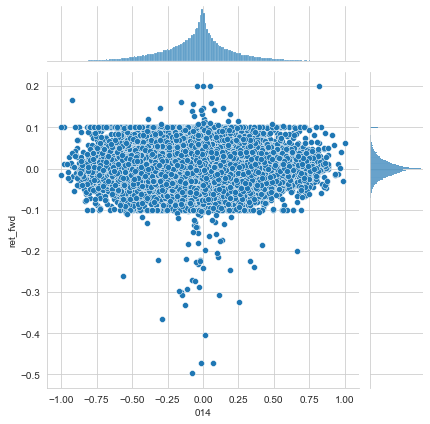

In [166]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [167]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [168]:
mi[alpha]

0.00041117649057120786

## Alpha 015

```
(-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))
```

In [170]:
def alpha015(h, v):
    """(-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))"""
    alpha = (-ts_sum(rank(ts_corr(rank(h), rank(v), 3)
                          .replace([-np.inf, np.inf], np.nan)), 3))
    return (alpha
            .stack('code')
            .swaplevel())

In [171]:
alpha = 15

In [172]:
%%time
alphas[f'{alpha:03}'] = alpha015(h, v)

CPU times: total: 219 ms
Wall time: 343 ms


In [146]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

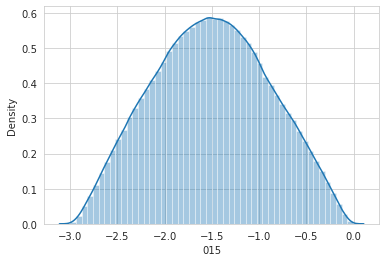

In [147]:
sns.distplot(alphas[f'{alpha:03}']);

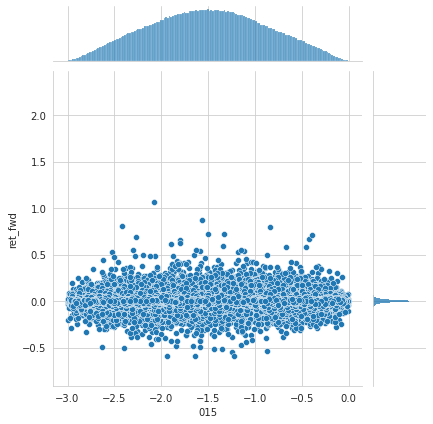

In [148]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [149]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [150]:
mi[alpha]

0.0011393971145832182

## Alpha 016

```
(-1 * rank(ts_cov(rank(high), rank(volume), 5)))```

In [151]:
def alpha016(h, v):
    """(-1 * rank(ts_cov(rank(high), rank(volume), 5)))"""
    return (-rank(ts_cov(rank(h), rank(v), 5))
            .stack('code')
            .swaplevel())

In [152]:
alpha = 16

In [153]:
%%time
alphas[f'{alpha:03}'] = alpha016(h, v)

CPU times: user 2.89 s, sys: 44.1 ms, total: 2.94 s
Wall time: 2.91 s


In [154]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

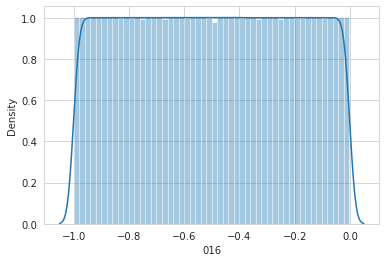

In [155]:
sns.distplot(alphas[f'{alpha:03}']);

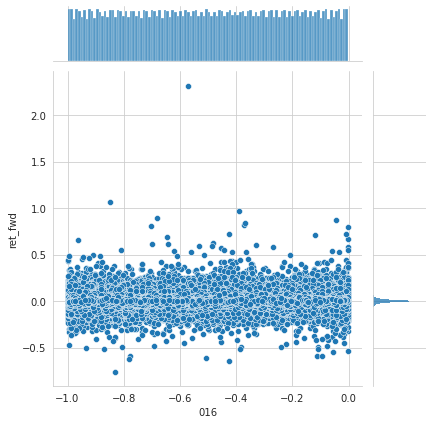

In [156]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [157]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [158]:
mi[alpha]

0

In [159]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 017

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [160]:
def alpha017(c, v):
    """(((-1 * rank(ts_rank(close, 10))) * rank(ts_delta(ts_delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))
        """
    adv20 = ts_mean(v, 20)
    return (-rank(ts_rank(c, 10))
            .mul(rank(ts_delta(ts_delta(c, 1), 1)))
            .mul(rank(ts_rank(v.div(adv20), 5)))
            .stack('code')
            .swaplevel())

In [161]:
alpha = 17

In [162]:
%%time
alphas[f'{alpha:03}'] = alpha017(c, v)

CPU times: user 5min 59s, sys: 127 ms, total: 5min 59s
Wall time: 5min 59s


In [163]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

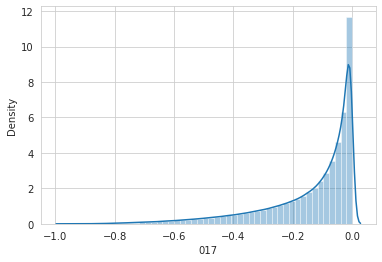

In [164]:
sns.distplot(alphas[f'{alpha:03}']);

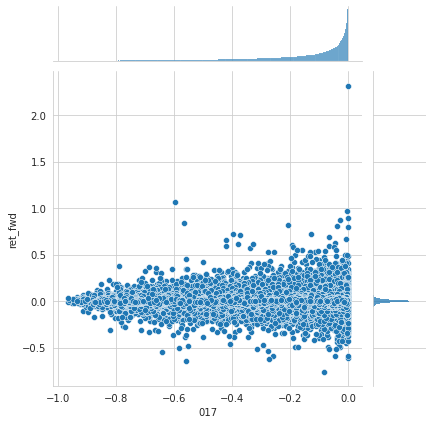

In [165]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [166]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [167]:
mi[alpha]

0

## Alpha 018

```
-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
```

In [168]:
def alpha018(o, c):
    """-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
    """
    return (-rank(ts_std(c.sub(o).abs(), 5)
                  .add(c.sub(o))
                  .add(ts_corr(c, o, 10)
                       .replace([-np.inf,
                                 np.inf],
                                np.nan)))
            .stack('code')
            .swaplevel())

In [169]:
alpha = 18

In [170]:
%%time
alphas[f'{alpha:03}'] = alpha018(o, c)

CPU times: user 3.64 s, sys: 84.1 ms, total: 3.72 s
Wall time: 3.64 s


In [171]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

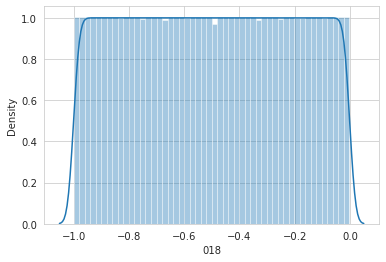

In [172]:
sns.distplot(alphas[f'{alpha:03}']);

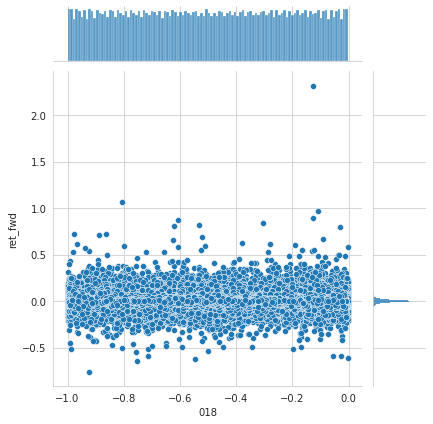

In [173]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [174]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [175]:
mi[alpha]

0

## Alpha 019

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [176]:
def alpha019(c, r):
    """((-1 * sign(((close - ts_lag(close, 7)) + ts_delta(close, 7)))) * 
    (1 + rank((1 + ts_sum(returns,250)))))
    """
    return (-sign(ts_delta(c, 7) + ts_delta(c, 7))
            .mul(1 + rank(1 + ts_sum(r, 250)))
            .stack('code')
            .swaplevel())

In [177]:
alpha = 19

In [178]:
%%time
alphas[f'{alpha:03}'] = alpha019(c, r)

CPU times: user 2.33 s, sys: 24 ms, total: 2.36 s
Wall time: 2.33 s


In [179]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

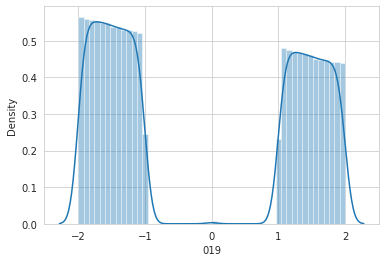

In [180]:
sns.distplot(alphas[f'{alpha:03}']);

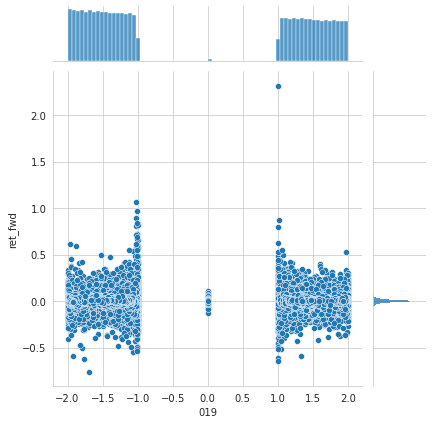

In [181]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [182]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [183]:
mi[alpha]

0.010082898712334476

In [184]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 020

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [185]:
def alpha020(o, h, l, c):
    """-rank(open - ts_lag(high, 1)) * 
        rank(open - ts_lag(close, 1)) * 
        rank(open -ts_lag(low, 1))"""
    return (rank(o - ts_lag(h, 1))
            .mul(rank(o - ts_lag(c, 1)))
            .mul(rank(o - ts_lag(l, 1)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [186]:
alpha = 20

In [187]:
%%time
alphas[f'{alpha:03}'] = alpha020(o, h, l, c)

CPU times: user 2.4 s, sys: 64 ms, total: 2.47 s
Wall time: 2.4 s


In [188]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

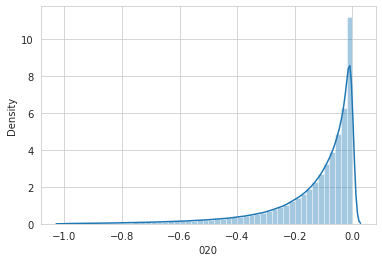

In [189]:
sns.distplot(alphas[f'{alpha:03}']);

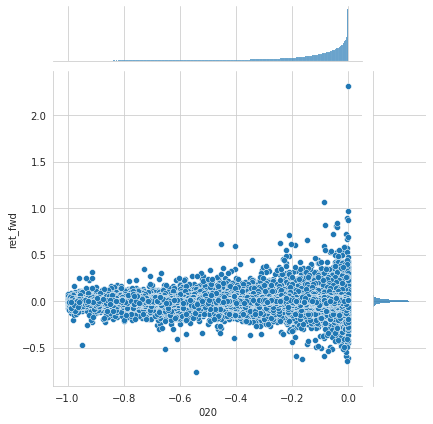

In [190]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [191]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [192]:
mi[alpha]

0.002095780517723078

## Alpha 021

```
ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1 
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1 
            : (volume / adv20 < 1
                ? -1 
                : 1))
```

In [193]:
def alpha021(c, v):
    """ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1
            : (volume / adv20 < 1
                ? -1
                : 1))
    """
    sma2 = ts_mean(c, 2)
    sma8 = ts_mean(c, 8)
    std8 = ts_std(c, 8)

    cond_1 = sma8.add(std8) < sma2
    cond_2 = sma8.add(std8) > sma2
    cond_3 = v.div(ts_mean(v, 20)) < 1

    val = np.ones_like(c)
    alpha = pd.DataFrame(np.select(condlist=[cond_1, cond_2, cond_3],
                                   choicelist=[-1, 1, -1], default=1),
                         index=c.index,
                         columns=c.columns)

    return (alpha
            .stack('code')
            .swaplevel())

In [194]:
alpha = 21

In [195]:
%%time
alphas[f'{alpha:03}'] = alpha021(c, v)

CPU times: user 2.15 s, sys: 16 ms, total: 2.17 s
Wall time: 2.13 s


In [196]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [197]:
alphas[f'{alpha:03}'].value_counts()

 1    1211187
-1      43906
Name: 021, dtype: int64

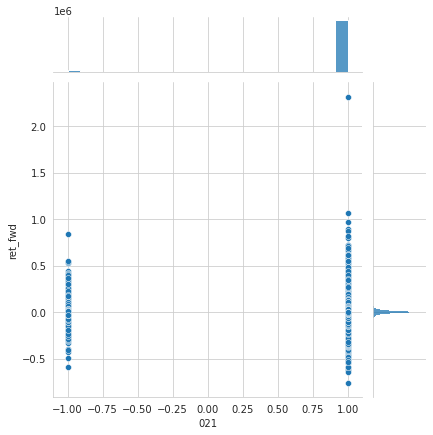

In [198]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [199]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [200]:
# mi[alpha]

## Alpha 022

```
-(ts_delta(ts_corr(high, volume, 5), 5) * 
        rank(ts_std(close, 20)))
```

In [201]:
def alpha022(h, c, v):
    """-(ts_delta(ts_corr(high, volume, 5), 5) * 
        rank(ts_std(close, 20)))
    """

    return (ts_delta(ts_corr(h, v, 5)
                     .replace([-np.inf,
                               np.inf],
                              np.nan), 5)
            .mul(rank(ts_std(c, 20)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [202]:
alpha = 22

In [203]:
%%time
alphas[f'{alpha:03}'] = alpha022(h, c, v)

CPU times: user 3.47 s, sys: 52.1 ms, total: 3.52 s
Wall time: 3.45 s


In [204]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

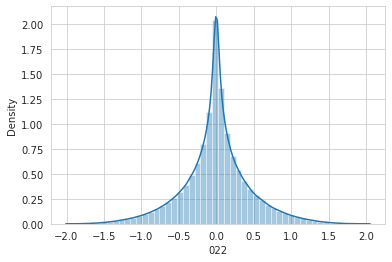

In [205]:
sns.distplot(alphas[f'{alpha:03}']);

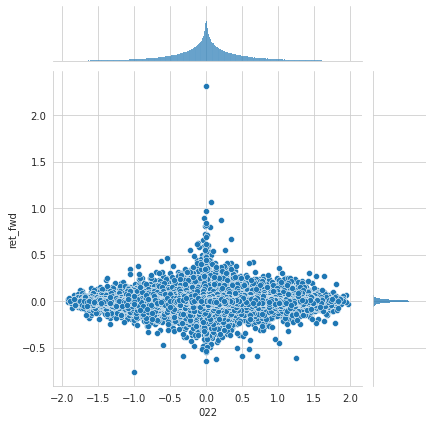

In [206]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [207]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [208]:
mi[alpha]

0.0025639008286280074

In [209]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 023

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [210]:
def alpha023(h, c):
    """((ts_mean(high, 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
        """

    return (ts_delta(h, 2)
            .mul(-1)
            .where(ts_mean(h, 20) < h, 0)
            .stack('code')
            .swaplevel())

In [211]:
alpha = 23

In [212]:
%%time
alphas[f'{alpha:03}'] = alpha023(h, c)

CPU times: user 2.49 s, sys: 8.05 ms, total: 2.5 s
Wall time: 2.48 s


In [213]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

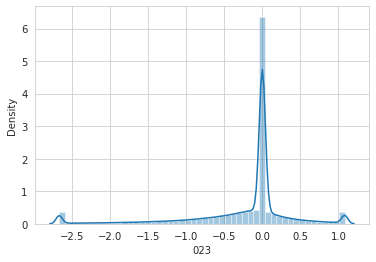

In [214]:
q = 0.025
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)));

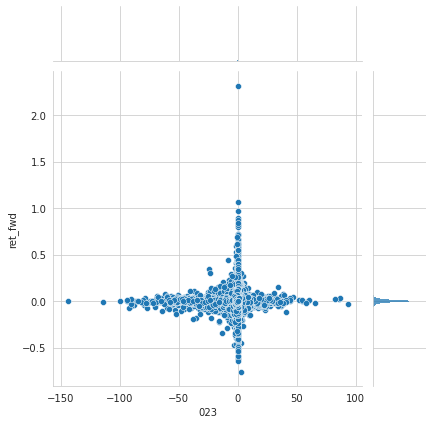

In [215]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [216]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [217]:
mi[alpha]

0.010802888976805036

## Alpha 024

```
((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
```

In [218]:
def alpha024(c):
    """((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
    """
    cond = ts_delta(ts_mean(c, 100), 100) / ts_lag(c, 100) <= 0.05

    return (c.sub(ts_min(c, 100)).mul(-1).where(cond, -ts_delta(c, 3))
            .stack('code')
            .swaplevel())

In [219]:
alpha = 24

In [220]:
%%time
alphas[f'{alpha:03}'] = alpha024(c)

CPU times: user 2.45 s, sys: 48 ms, total: 2.5 s
Wall time: 2.44 s


In [221]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

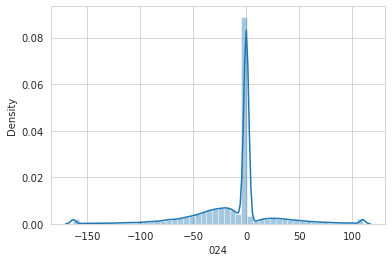

In [222]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)));

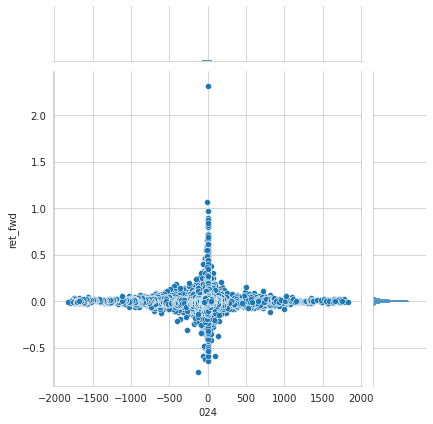

In [223]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [224]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [225]:
mi[alpha]

0.031433111296676586

## Alpha 025

```
rank((-1 * returns) * adv20 * vwap * (high - close))
```

In [226]:
def alpha025(h, c, r, vwap, adv20):
    """rank((-1 * returns) * adv20 * vwap * (high - close))"""
    return (rank(-r.mul(adv20)
                 .mul(vwap)
                 .mul(h.sub(c)))
            .stack('code')
            .swaplevel())

In [227]:
alpha = 25

In [228]:
%%time
alphas[f'{alpha:03}'] = alpha025(h, c, r, vwap, adv20)

CPU times: user 2.9 s, sys: 36 ms, total: 2.93 s
Wall time: 2.9 s


In [229]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

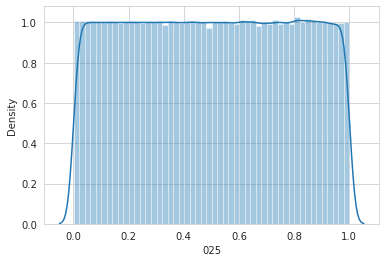

In [230]:
sns.distplot(alphas[f'{alpha:03}']);

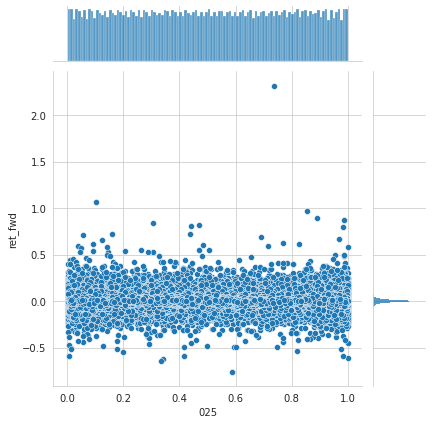

In [231]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [232]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [233]:
mi[alpha]

0.002047811727091897

In [234]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 026

```
(-1 * rank(ts_cov(rank(high), rank(volume), 5)))```

In [235]:
def alpha026(h, v):
    """(-1 * ts_max(ts_corr(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))"""
    return (ts_max(ts_corr(ts_rank(v, 5), 
                           ts_rank(h, 5), 5)
                   .replace([-np.inf, np.inf], np.nan), 3)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [236]:
alpha = 26

In [237]:
%%time
alphas[f'{alpha:03}'] = alpha026(h, v)

CPU times: user 6min 3s, sys: 148 ms, total: 6min 3s
Wall time: 6min 3s


In [238]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

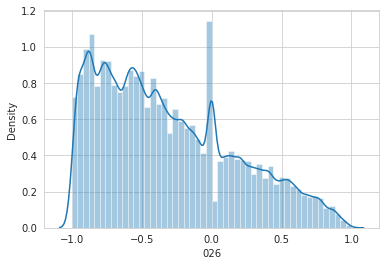

In [239]:
sns.distplot(alphas[f'{alpha:03}']);

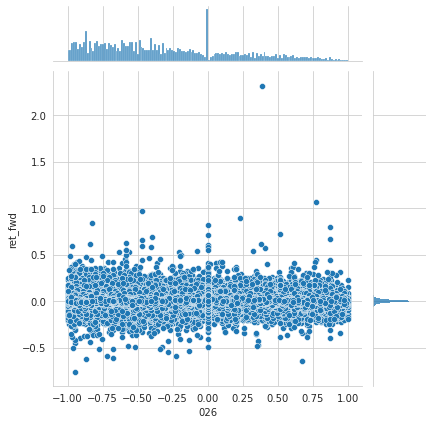

In [240]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [241]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [242]:
mi[alpha]

0.006628205346157046

## Alpha 027

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [243]:
def alpha027(v, vwap):
    """((0.5 < rank(ts_mean(ts_corr(rank(volume), rank(vwap), 6), 2))) 
            ? -1
            : 1)"""
    cond = rank(ts_mean(ts_corr(rank(v),
                                rank(vwap), 6), 2))
    alpha = cond.notnull().astype(float)
    return (alpha.where(cond <= 0.5, -alpha)
            .stack('code')
            .swaplevel())

In [244]:
alpha = 27

In [245]:
%%time
alphas[f'{alpha:03}'] = alpha027(v, vwap)

CPU times: user 3.65 s, sys: 28 ms, total: 3.68 s
Wall time: 3.64 s


In [246]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

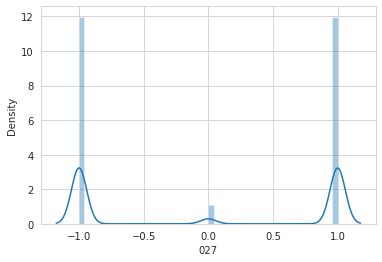

In [247]:
sns.distplot(alphas[f'{alpha:03}']);

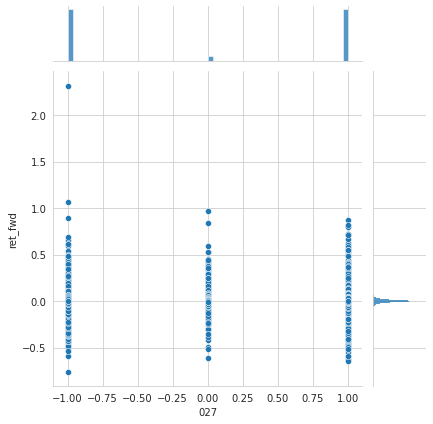

In [248]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [249]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [250]:
# mi[alpha]

## Alpha 028

```
-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
```

In [251]:
def alpha028(h, l, c, v, adv20):
    """scale(((ts_corr(adv20, low, 5) + (high + low) / 2) - close))"""
    return (scale(ts_corr(adv20, l, 5)
                  .replace([-np.inf, np.inf], 0)
                  .add(h.add(l).div(2).sub(c)))
            .stack('code')
            .swaplevel())

In [252]:
alpha = 28

In [253]:
%%time
alphas[f'{alpha:03}'] = alpha028(h, l, c, v, adv20)

CPU times: user 3.3 s, sys: 24 ms, total: 3.33 s
Wall time: 3.27 s


In [254]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

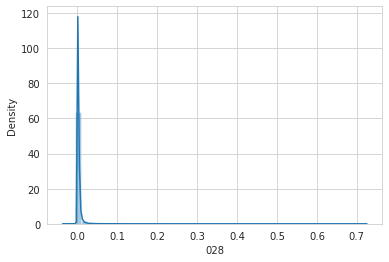

In [255]:
sns.distplot(alphas[f'{alpha:03}']);

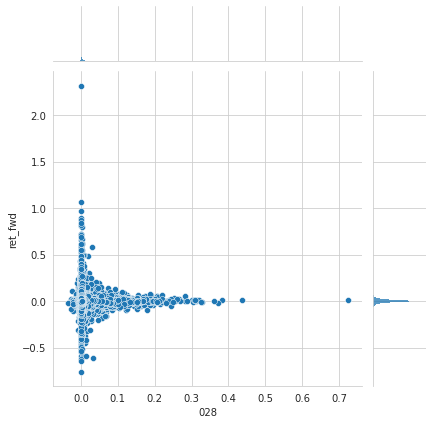

In [256]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [257]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [258]:
mi[alpha]

0.0064583435249003784

In [259]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 029

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [260]:
def alpha029(c, r):
    """(ts_min(ts_product(rank(rank(scale(log(ts_sum(ts_min(rank(rank((-1 * 
            rank(ts_delta((close - 1),5))))), 2), 1))))), 1), 5)
        + ts_rank(ts_lag((-1 * returns), 6), 5))
    """
    return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-rank(ts_delta((c - 1), 5)))), 2))))), 5)
            .add(ts_rank(ts_lag((-1 * r), 6), 5))
            .stack('code')
            .swaplevel())

In [261]:
alpha = 29

In [262]:
%%time
alphas[f'{alpha:03}'] = alpha029(c, r)

CPU times: user 3min 3s, sys: 188 ms, total: 3min 4s
Wall time: 3min 4s


In [263]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

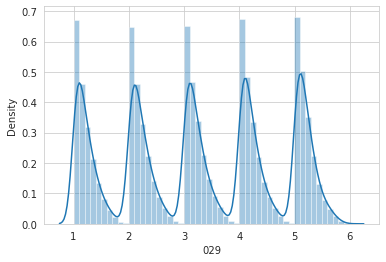

In [264]:
sns.distplot(alphas[f'{alpha:03}']);

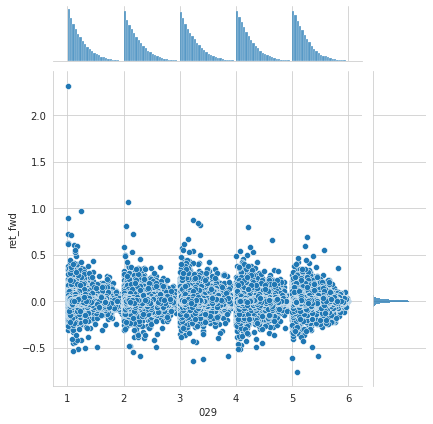

In [265]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [266]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [267]:
mi[alpha]

0.005814612612969228

## Alpha 030

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [268]:
def alpha030(c, v):
    """(((1.0 - rank(((sign((close - ts_lag(close, 1))) +
            sign((ts_lag(close, 1) - ts_lag(close, 2)))) +
            sign((ts_lag(close, 2) - ts_lag(close, 3)))))) *
            ts_sum(volume, 5)) / ts_sum(volume, 20))"""
    close_diff = ts_delta(c, 1)
    return (rank(sign(close_diff)
                 .add(sign(ts_lag(close_diff, 1)))
                 .add(sign(ts_lag(close_diff, 2))))
            .mul(-1).add(1)
            .mul(ts_sum(v, 5))
            .div(ts_sum(v, 20))
            .stack('code')
            .swaplevel())

In [269]:
alpha = 30

In [270]:
%%time
alphas[f'{alpha:03}'] = alpha030(c, v)

CPU times: user 2.39 s, sys: 48 ms, total: 2.44 s
Wall time: 2.38 s


In [271]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

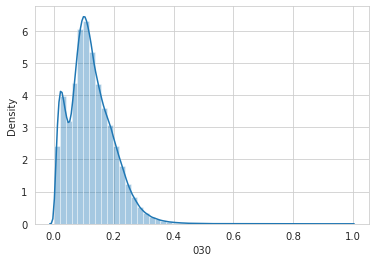

In [272]:
sns.distplot(alphas[f'{alpha:03}']);

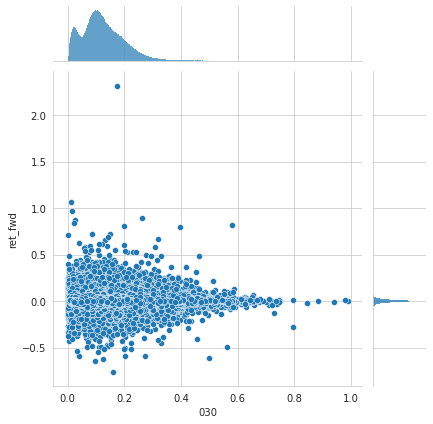

In [273]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [274]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [275]:
mi[alpha]

0

## Alpha 031

```
ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1 
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1 
            : (volume / adv20 < 1
                ? -1 
                : 1))
```

In [276]:
def alpha031(l, c, adv20):
    """((rank(rank(rank(ts_weighted_mean((-1 * rank(rank(ts_delta(close, 10)))), 10)))) +
        rank((-1 * ts_delta(close, 3)))) + sign(scale(ts_corr(adv20, low, 12))))
    """
    return (rank(rank(rank(ts_weighted_mean(rank(rank(ts_delta(c, 10))).mul(-1), 10))))
            .add(rank(ts_delta(c, 3).mul(-1)))
            .add(sign(scale(ts_corr(adv20, l, 12)
                            .replace([-np.inf, np.inf],
                                     np.nan))))
            .stack('code')
            .swaplevel())

In [277]:
alpha = 31

In [278]:
%%time
alphas[f'{alpha:03}'] = alpha031(l, c, adv20)

CPU times: user 3.66 s, sys: 15.9 ms, total: 3.68 s
Wall time: 3.61 s


In [279]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

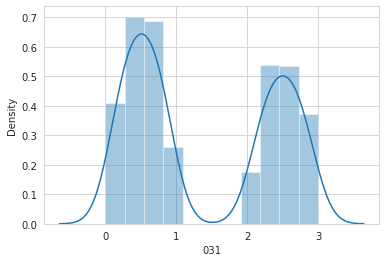

In [280]:
sns.distplot(alphas[f'{alpha:03}']);

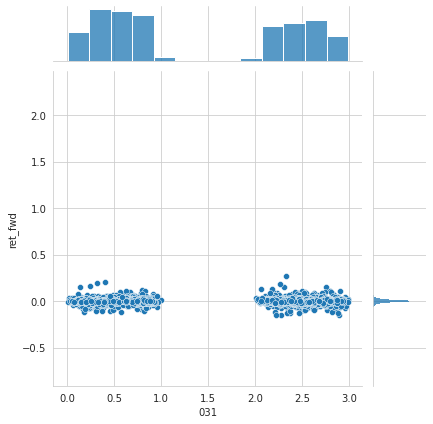

In [281]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 032

```
scale(ts_mean(close, 7) - close) + 
        (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))```

In [282]:
def alpha032(c, vwap):
    """scale(ts_mean(close, 7) - close) + 
        (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))"""
    return (scale(ts_mean(c, 7).sub(c))
            .add(20 * scale(ts_corr(vwap,
                                    ts_lag(c, 5), 230)))
            .stack('code')
            .swaplevel())

In [283]:
alpha = 32

In [284]:
%%time
alphas[f'{alpha:03}'] = alpha032(c, vwap)

CPU times: user 3.68 s, sys: 15.9 ms, total: 3.69 s
Wall time: 3.63 s


In [285]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

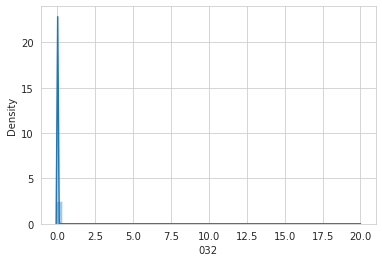

In [286]:
sns.distplot(alphas[f'{alpha:03}']);

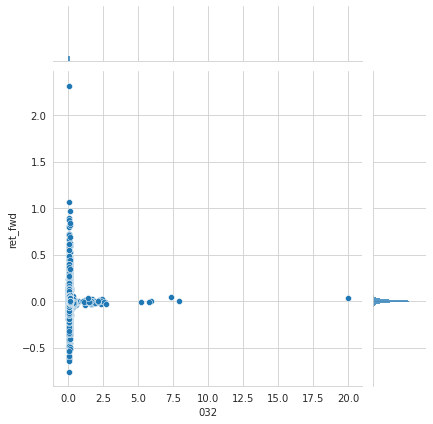

In [287]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [288]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, 
                                  alphas[f'{alpha:03}'])

In [289]:
mi[alpha]

0.015078606589863597

## Alpha 033

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [290]:
def alpha033(o, c):
    """rank(-(1 - (open / close)))"""
    return (rank(o.div(c).mul(-1).add(1).mul(-1))
            .stack('code')
            .swaplevel())

In [291]:
alpha = 33

In [292]:
%%time
alphas[f'{alpha:03}'] = alpha033(o, c)

CPU times: user 2.66 s, sys: 12 ms, total: 2.67 s
Wall time: 2.64 s


In [293]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

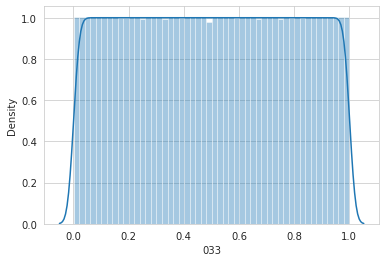

In [294]:
sns.distplot(alphas[f'{alpha:03}']);

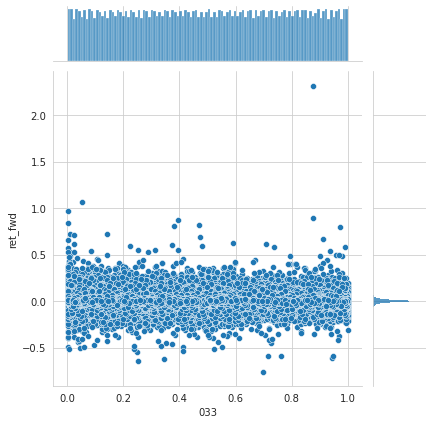

In [295]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [296]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [297]:
mi[alpha]

0.003290483361809038

## Alpha 034

```
((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
```

In [298]:
def alpha034(c, r):
    """rank(((1 - rank((ts_std(returns, 2) / ts_std(returns, 5)))) + (1 - rank(ts_delta(close, 1)))))"""

    return (rank(rank(ts_std(r, 2).div(ts_std(r, 5))
                      .replace([-np.inf, np.inf],
                               np.nan))
                 .mul(-1)
                 .sub(rank(ts_delta(c, 1)))
                 .add(2))
            .stack('code')
            .swaplevel())

In [299]:
alpha = 34

In [300]:
%%time
alphas[f'{alpha:03}'] = alpha034(c, r)

CPU times: user 1.75 s, sys: 8 ms, total: 1.76 s
Wall time: 1.73 s


In [301]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

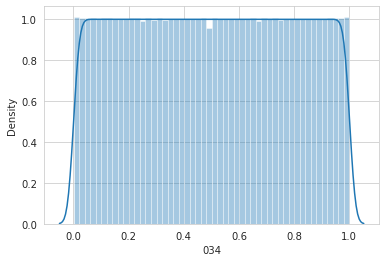

In [302]:
sns.distplot(alphas[f'{alpha:03}']);

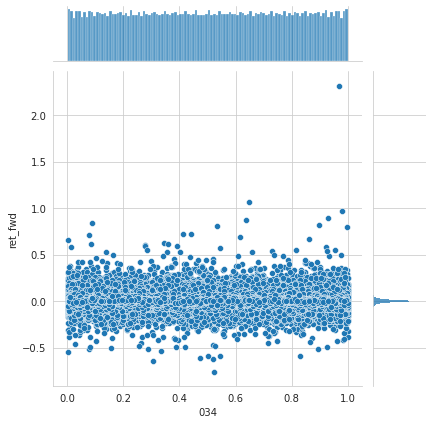

In [303]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [304]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [305]:
mi[alpha]

0

In [306]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 035

```
rank((-1 * returns) * adv20 * vwap * (high - close))
```

In [307]:
def alpha035(h, l, c, v, r):
    """((ts_Rank(volume, 32) *
        (1 - ts_Rank(((close + high) - low), 16))) *
        (1 -ts_Rank(returns, 32)))
    """
    return (ts_rank(v, 32)
            .mul(1 - ts_rank(c.add(h).sub(l), 16))
            .mul(1 - ts_rank(r, 32))
            .stack('code')
            .swaplevel())

In [308]:
alpha = 35

In [309]:
%%time
alphas[f'{alpha:03}'] = alpha035(h, l, c, v, r)

CPU times: user 9min 1s, sys: 95.8 ms, total: 9min 1s
Wall time: 9min 1s


In [310]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

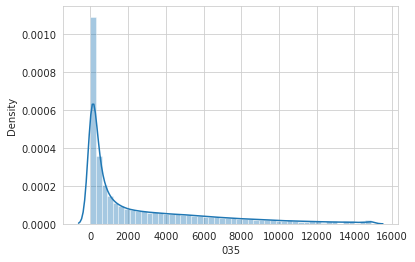

In [311]:
sns.distplot(alphas[f'{alpha:03}']);

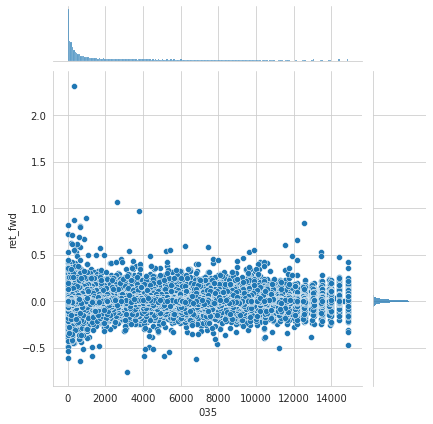

In [312]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [313]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [314]:
mi[alpha]

0

## Alpha 036

```
2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) +
0.7 * rank((open- close)) +
0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) +
rank(abs(ts_corr(vwap,adv20, 6))) +
0.6 * rank(((ts_mean(close, 200) - open) * (close - open)))
```

In [315]:
def alpha036(o, c, v, r, adv20):
    """2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) +
        0.7 * rank((open- close)) +
        0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) +
        rank(abs(ts_corr(vwap,adv20, 6))) +
        0.6 * rank(((ts_mean(close, 200) - open) * (close - open)))
    """

    return (rank(ts_corr(c.sub(o), ts_lag(v, 1), 15)).mul(2.21)
            .add(rank(o.sub(c)).mul(.7))
            .add(rank(ts_rank(ts_lag(-r, 6), 5)).mul(0.73))
            .add(rank(abs(ts_corr(vwap, adv20, 6))))
            .add(rank(ts_mean(c, 200).sub(o).mul(c.sub(o))).mul(0.6))
            .stack('code')
            .swaplevel())

In [316]:
alpha = 36

In [317]:
%%time
alphas[f'{alpha:03}'] = alpha036(o, c, v, r, adv20)

CPU times: user 3min 5s, sys: 51.9 ms, total: 3min 5s
Wall time: 3min 5s


In [318]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

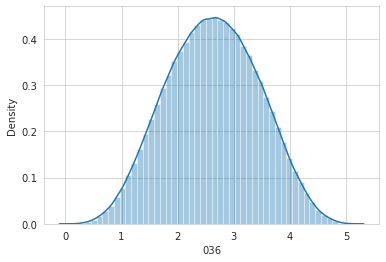

In [319]:
sns.distplot(alphas[f'{alpha:03}']);

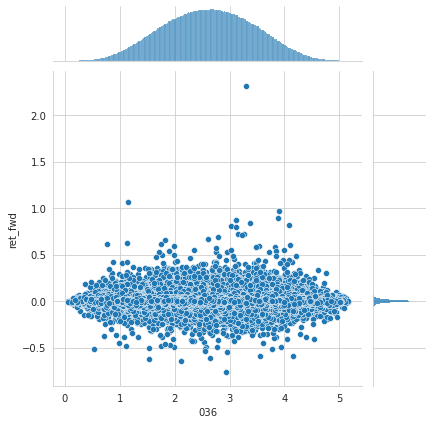

In [320]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [321]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [322]:
mi[alpha]

0.0017091501300177114

## Alpha 037

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [323]:
def alpha037(o, c):
    """(rank(ts_corr(ts_lag((open - close), 1), close, 200)) + rank((open - close)))"""
    return (rank(ts_corr(ts_lag(o.sub(c), 1), c, 200))
            .add(rank(o.sub(c)))
            .stack('code')
            .swaplevel())

In [324]:
alpha = 37

In [325]:
%%time
alphas[f'{alpha:03}'] = alpha037(o, c)

CPU times: user 3.51 s, sys: 32 ms, total: 3.54 s
Wall time: 3.49 s


In [326]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

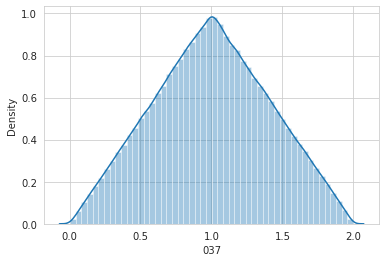

In [327]:
sns.distplot(alphas[f'{alpha:03}']);

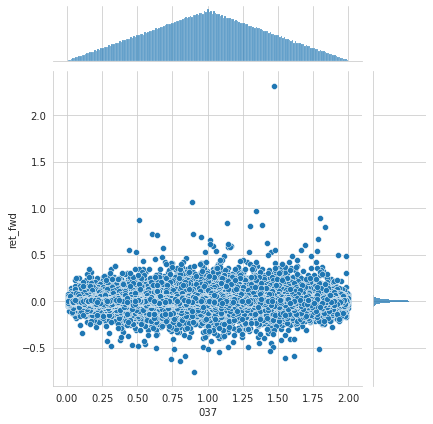

In [328]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [329]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [330]:
mi[alpha]

0.0011419189372663396

In [331]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 038

```
1 * rank(ts_rank(close, 10)) * rank(close / open)
```

In [332]:
def alpha038(o, c):
    """"-1 * rank(ts_rank(close, 10)) * rank(close / open)"""
    return (rank(ts_rank(o, 10))
            .mul(rank(c.div(o).replace([-np.inf, np.inf], np.nan)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [333]:
alpha = 38

In [334]:
%%time
alphas[f'{alpha:03}'] = alpha038(o, c)

CPU times: user 3min 5s, sys: 15.9 ms, total: 3min 5s
Wall time: 3min 5s


In [335]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

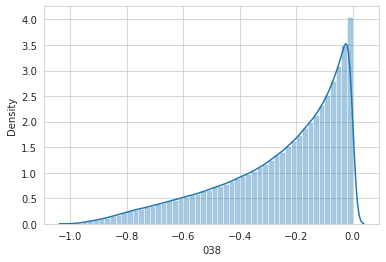

In [336]:
sns.distplot(alphas[f'{alpha:03}']);

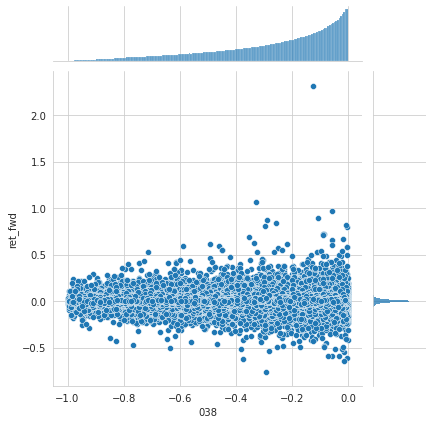

In [337]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [338]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [339]:
mi[alpha]

0.003271738846891026

## Alpha 039

```
-rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) * 
    (1 + rank(ts_sum(returns, 250)))
```

In [340]:
def alpha039(c, v, r, adv20):
    """-rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) * 
            (1 + rank(ts_sum(returns, 250)))"""
    return (rank(ts_delta(c, 7).mul(rank(ts_weighted_mean(v.div(adv20), 9)).mul(-1).add(1))).mul(-1)
            .mul(rank(ts_mean(r, 250).add(1)))
            .stack('code')
            .swaplevel())

In [341]:
alpha = 39

In [342]:
%%time
alphas[f'{alpha:03}'] = alpha039(c, v, r, adv20)

CPU times: user 2.55 s, sys: 16 ms, total: 2.56 s
Wall time: 2.5 s


In [343]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

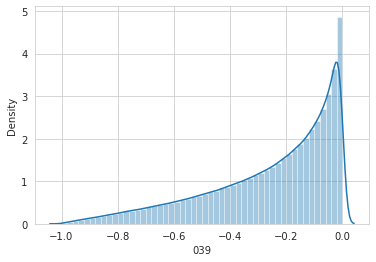

In [344]:
sns.distplot(alphas[f'{alpha:03}']);

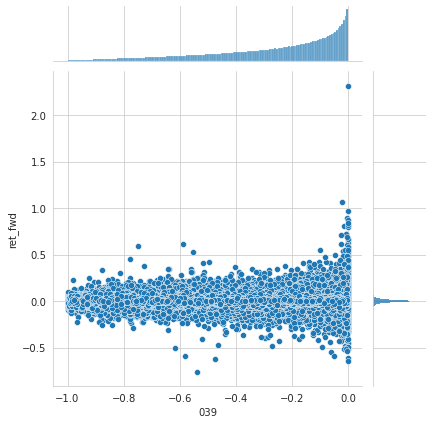

In [345]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [346]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [347]:
mi[alpha]

0.0021417818275919487

## Alpha 040

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [348]:
def alpha040(h, v):
    """((-1 * rank(ts_std(high, 10))) * ts_corr(high, volume, 10))
    """
    return (rank(ts_std(h, 10))
            .mul(ts_corr(h, v, 10))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [349]:
alpha = 40

In [350]:
%%time
alphas[f'{alpha:03}'] = alpha040(h, v)

CPU times: user 3.71 s, sys: 15.9 ms, total: 3.72 s
Wall time: 3.68 s


In [351]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

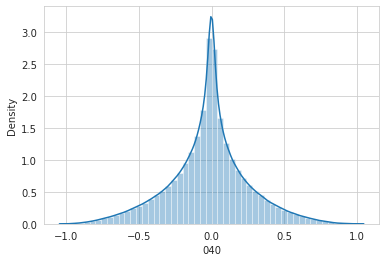

In [352]:
sns.distplot(alphas[f'{alpha:03}']);

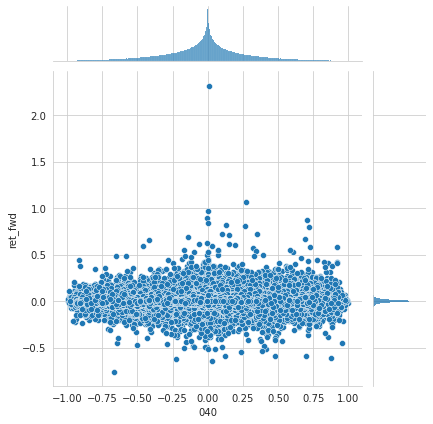

In [353]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [354]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.008389463848225809

## Alpha 041

```
power(high * low, 0.5) - vwap```

In [355]:
def alpha041(h, l, vwap):
    """power(high * low, 0.5 - vwap"""
    return (power(h.mul(l), 0.5)
            .sub(vwap)
            .stack('code')
            .swaplevel())

In [356]:
alpha = 41

In [357]:
%%time
alphas[f'{alpha:03}'] = alpha041(h, l, vwap)

CPU times: user 2.32 s, sys: 16 ms, total: 2.34 s
Wall time: 2.3 s


In [358]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

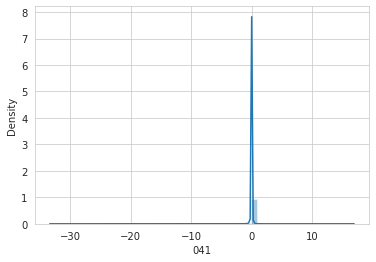

In [359]:
sns.distplot(alphas[f'{alpha:03}']);

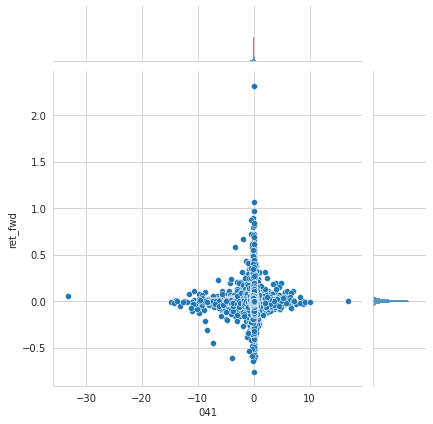

In [360]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [361]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004631922179492598

## Alpha 042

```
rank(vwap - close) / rank(vwap + close)
```

In [362]:
def alpha042(c, vwap):
    """rank(vwap - close) / rank(vwap + close)"""
    return (rank(vwap.sub(c))
            .div(rank(vwap.add(c)))
            .stack('code')
            .swaplevel())

In [363]:
alpha = 42

In [364]:
%%time
alphas[f'{alpha:03}'] = alpha042(c, vwap)

CPU times: user 2.43 s, sys: 36 ms, total: 2.46 s
Wall time: 2.43 s


In [365]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

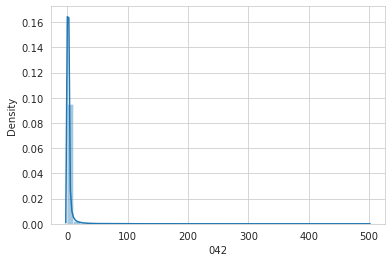

In [366]:
sns.distplot(alphas[f'{alpha:03}']);

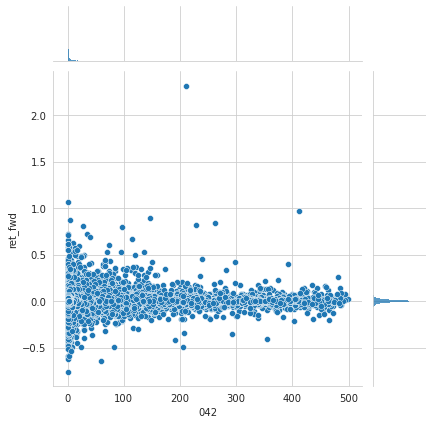

In [367]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [368]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0003211794350050923

## Alpha 043

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [369]:
def alpha043(c, adv20):
    """(ts_rank((volume / adv20), 20) * ts_rank((-1 * ts_delta(close, 7)), 8))"""

    return (ts_rank(v.div(adv20), 20)
            .mul(ts_rank(ts_delta(c, 7).mul(-1), 8))
            .stack('code')
            .swaplevel())

In [370]:
alpha = 43

In [371]:
%%time
alphas[f'{alpha:03}'] = alpha043(c, adv20)

CPU times: user 6min 2s, sys: 72 ms, total: 6min 2s
Wall time: 6min 2s


In [372]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

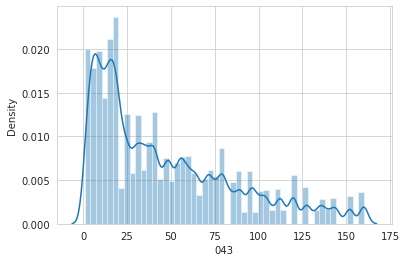

In [373]:
sns.distplot(alphas[f'{alpha:03}']);

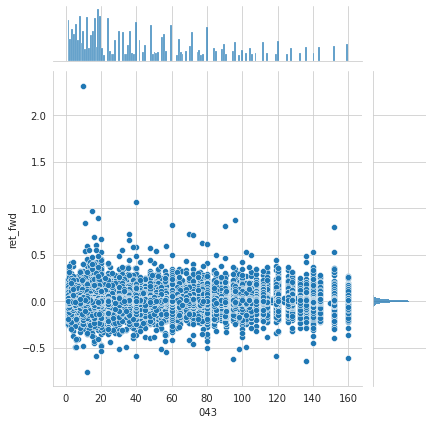

In [374]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [375]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

3.31646414482023e-05

## Alpha 044

```
-ts_corr(high, rank(volume), 5)
```

In [376]:
def alpha044(h, v):
    """-ts_corr(high, rank(volume), 5)"""

    return (ts_corr(h, rank(v), 5)
            .replace([-np.inf, np.inf], np.nan)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [377]:
alpha = 44

In [378]:
%%time
alphas[f'{alpha:03}'] = alpha044(h, v)

CPU times: user 3.69 s, sys: 28 ms, total: 3.72 s
Wall time: 3.69 s


In [379]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

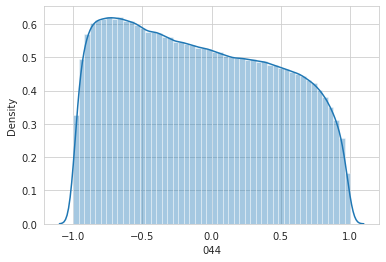

In [380]:
sns.distplot(alphas[f'{alpha:03}']);

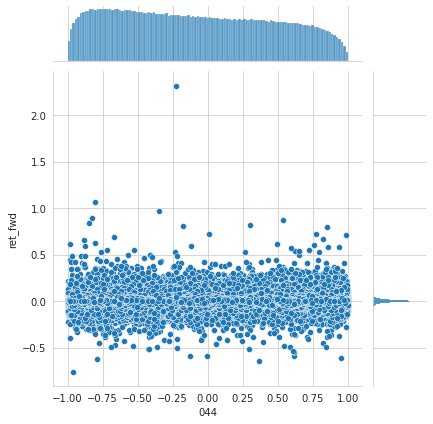

In [381]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [382]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 045

```
-(rank((ts_mean(ts_lag(close, 5), 20)) * 
        ts_corr(close, volume, 2)) *
        rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2)))
```

In [383]:
def alpha045(c, v):
    """-(rank((ts_mean(ts_lag(close, 5), 20)) * 
        ts_corr(close, volume, 2)) *
        rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2)))"""

    return (rank(ts_mean(ts_lag(c, 5), 20))
            .mul(ts_corr(c, v, 2)
                 .replace([-np.inf, np.inf], np.nan))
            .mul(rank(ts_corr(ts_sum(c, 5),
                              ts_sum(c, 20), 2)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [384]:
alpha = 45

In [385]:
%%time
alphas[f'{alpha:03}'] = alpha045(c, v)

CPU times: user 5.26 s, sys: 76 ms, total: 5.33 s
Wall time: 5.18 s


In [386]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

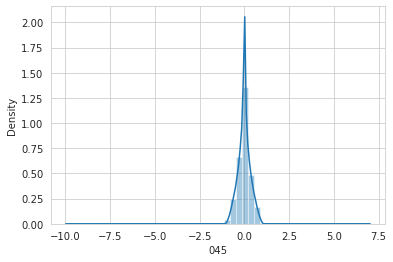

In [387]:
sns.distplot(alphas[f'{alpha:03}']);

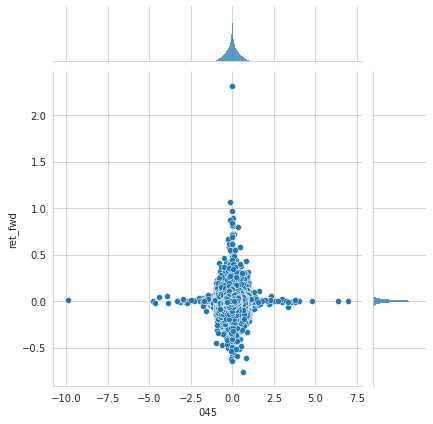

In [388]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [389]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.008224194668740914

## Alpha 046

```
0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10
    ? -1
    : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) 
        ? 1 
        : -ts_delta(close, 1))
```

In [390]:
def alpha046(c):
    """0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10
            ? -1
            : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) 
                ? 1 
                : -ts_delta(close, 1))
    """

    cond = ts_lag(ts_delta(c, 10), 10).div(10).sub(ts_delta(c, 10).div(10))
    alpha = pd.DataFrame(-np.ones_like(cond),
                         index=c.index,
                         columns=c.columns)
    alpha[cond.isnull()] = np.nan
    return (cond.where(cond > 0.25,
                       -alpha.where(cond < 0,
                       -ts_delta(c, 1)))
            .stack('code')
            .swaplevel())

In [391]:
alpha = 46

In [392]:
%%time
alphas[f'{alpha:03}'] = alpha046(c)

CPU times: user 2.37 s, sys: 12 ms, total: 2.38 s
Wall time: 2.34 s


In [393]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

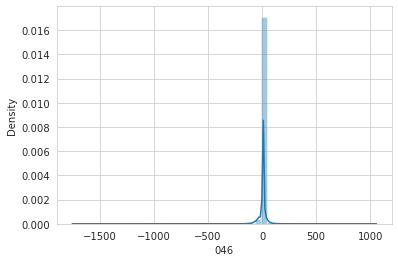

In [394]:
sns.distplot(alphas[f'{alpha:03}']);

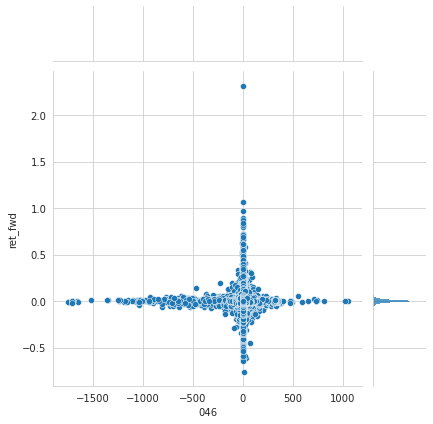

In [395]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [396]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.00870732283747122

## Alpha 047

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [397]:
def alpha047(h, c, v, vwap, adv20):
    """((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / 
        (ts_sum(high, 5) /5))) - rank((vwap - ts_lag(vwap, 5))))"""

    return (rank(c.pow(-1)).mul(v).div(adv20)
            .mul(h.mul(rank(h.sub(c))
                       .div(ts_mean(h, 5)))
                 .sub(rank(ts_delta(vwap, 5))))
            .stack('code')
            .swaplevel())

In [398]:
alpha = 47

In [399]:
%%time
alphas[f'{alpha:03}'] = alpha047(h, c, v, vwap, adv20)

CPU times: user 2.87 s, sys: 64.1 ms, total: 2.93 s
Wall time: 2.81 s


In [400]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

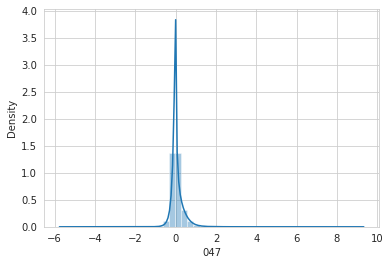

In [401]:
sns.distplot(alphas[f'{alpha:03}']);

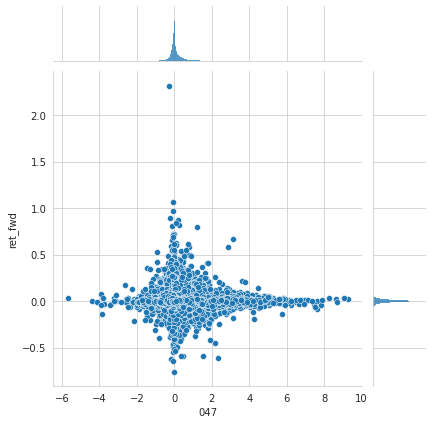

In [402]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [403]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0009995443357944112

## Alpha 048

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [404]:
def alpha48(c, industry):
    """(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) * 
        ts_delta(close, 1)) / close), IndClass.subindustry) / 
        ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))"""
    pass

In [405]:
alpha = 48

In [406]:
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)

In [407]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [408]:
# sns.distplot(alphas[f'{alpha:03}']);

In [409]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [410]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 049

```
ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c
        ? 1 
        : -ts_delta(close, 1)
```

In [411]:
def alpha049(c):
    """ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c
        ? 1 
        : -ts_delta(close, 1)"""
    cond = (ts_delta(ts_lag(c, 10), 10).div(10)
            .sub(ts_delta(c, 10).div(10)) >= -0.1 * c)
    return (-ts_delta(c, 1)
            .where(cond, 1)
            .stack('code')
            .swaplevel())

In [412]:
alpha = 49

In [413]:
%%time
alphas[f'{alpha:03}'] = alpha049(c)

CPU times: user 3.13 s, sys: 32 ms, total: 3.16 s
Wall time: 3.12 s


In [414]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

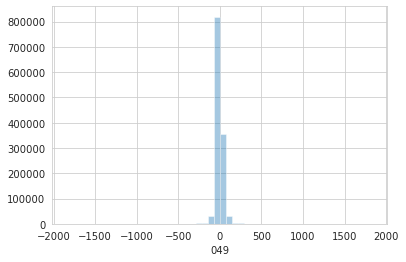

In [415]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

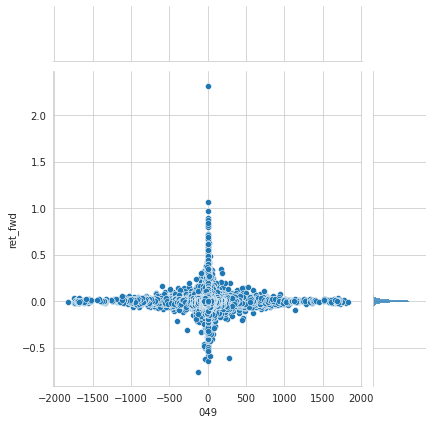

In [416]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 050

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [417]:
def alpha050(v, vwap):
    """-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)"""
    return (ts_max(rank(ts_corr(rank(v),
                                rank(vwap), 5)), 5)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [418]:
alpha = 50

In [419]:
%%time
alphas[f'{alpha:03}'] = alpha050(v, vwap)

CPU times: user 2.98 s, sys: 88 ms, total: 3.07 s
Wall time: 3.01 s


In [420]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

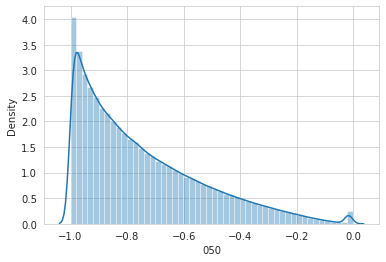

In [421]:
sns.distplot(alphas[f'{alpha:03}']);

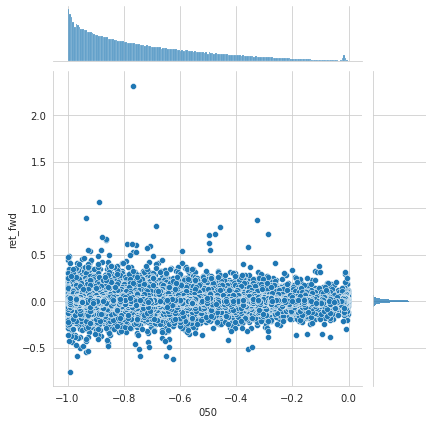

In [422]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [423]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 051

```
ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c
        ? 1 
        : -ts_delta(close, 1)
```

In [424]:
def alpha051(c):
    """ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c
        ? 1 
        : -ts_delta(close, 1)"""
    cond = (ts_delta(ts_lag(c, 10), 10).div(10)
            .sub(ts_delta(c, 10).div(10)) >= -0.05 * c)
    return (-ts_delta(c, 1)
            .where(cond, 1)
            .stack('code')
            .swaplevel())

In [425]:
alpha = 51

In [426]:
%%time
alphas[f'{alpha:03}'] = alpha051(c)

CPU times: user 5.92 s, sys: 128 ms, total: 6.05 s
Wall time: 6 s


In [427]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

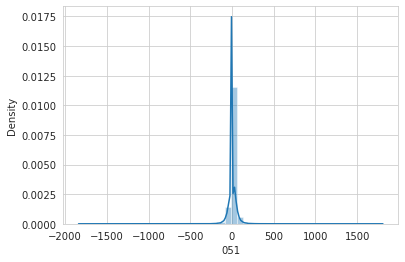

In [428]:
sns.distplot(alphas[f'{alpha:03}']);

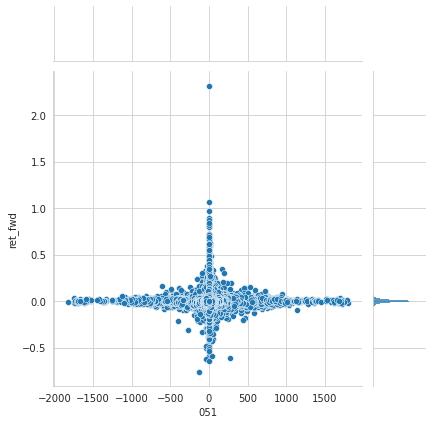

In [429]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [430]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.010624389695808034

## Alpha 052

```
(ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) * 
        rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) * 
        ts_rank(volume, 5)
```

In [431]:
def alpha052(l, v, r):
    """(ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) * 
        rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) * 
        ts_rank(volume, 5)
    """
    return (ts_delta(ts_min(l, 5), 5)
            .mul(rank(ts_sum(r, 240)
                      .sub(ts_sum(r, 20))
                      .div(220)))
            .mul(ts_rank(v, 5))
            .stack('code')
            .swaplevel())

In [432]:
alpha = 52

In [433]:
%%time
alphas[f'{alpha:03}'] = alpha052(l, v, r)

CPU times: user 3min 4s, sys: 52 ms, total: 3min 4s
Wall time: 3min 4s


In [434]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

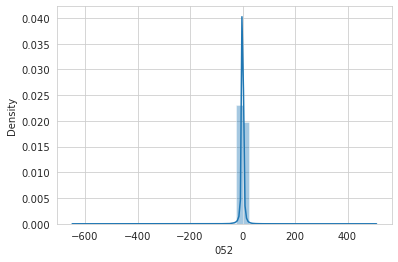

In [435]:
sns.distplot(alphas[f'{alpha:03}']);

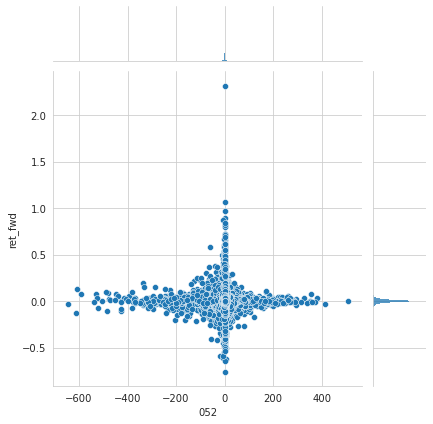

In [436]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [437]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.007025458925477679

## Alpha 053

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [438]:
def alpha053(h, l, c):
    """-1 * ts_delta(1 - (high - close) / (close - low), 9)"""
    inner = (c.sub(l)).add(1e-6)
    return (ts_delta(h.sub(c)
                     .mul(-1).add(1)
                     .div(c.sub(l)
                          .add(1e-6)), 9)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [439]:
alpha = 53

In [440]:
%%time
alphas[f'{alpha:03}'] = alpha053(h, l, c)

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.45 s


In [441]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

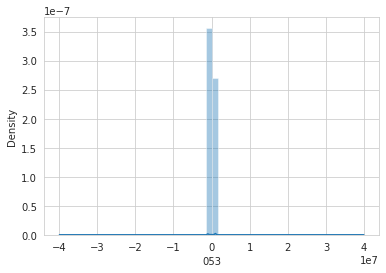

In [442]:
sns.distplot(alphas[f'{alpha:03}']);

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 054

```
-(low - close) * power(open, 5) / ((low - high) * power(close, 5))
```

In [35]:
def alpha054(o, h, l, c):
    """-(low - close) * power(open, 5) / ((low - high) * power(close, 5))"""
    return (l.sub(c).mul(o.pow(5)).mul(-1)
            .div(l.sub(h).replace(0, -0.0001).mul(c ** 5))
            .stack('code')
            .swaplevel())

In [36]:
alpha = 54

In [37]:
%%time
alphas[f'{alpha:03}'] = alpha054(o, h, l, c)

CPU times: user 1.99 s, sys: 42.8 ms, total: 2.03 s
Wall time: 1.91 s


In [38]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

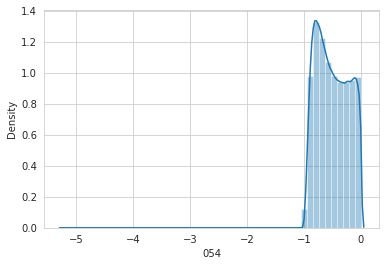

In [39]:
sns.distplot(alphas[f'{alpha:03}']);

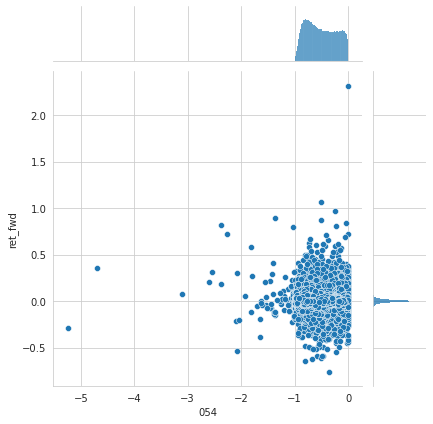

In [40]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [41]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0007175455210228776

In [42]:
pd.Series(mi).tail()

54    0.000718
dtype: float64

## Alpha 055

```
(-1 * ts_corr(rank(((close - ts_min(low, 12)) / 
                            (ts_max(high, 12) - ts_min(low,12)))), 
                    rank(volume), 6))
```

In [43]:
def alpha055(h, l, c):
    """(-1 * ts_corr(rank(((close - ts_min(low, 12)) / 
                            (ts_max(high, 12) - ts_min(low,12)))), 
                    rank(volume), 6))"""

    return (ts_corr(rank(c.sub(ts_min(l, 12))
                         .div(ts_max(h, 12).sub(ts_min(l, 12))
                              .replace(0, 1e-6))),
                    rank(v), 6)
            .replace([-np.inf, np.inf], np.nan)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [44]:
alpha = 55

In [45]:
%%time
alphas[f'{alpha:03}'] = alpha055(h, l, c)

CPU times: user 3.83 s, sys: 65.4 ms, total: 3.89 s
Wall time: 3.81 s


In [46]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

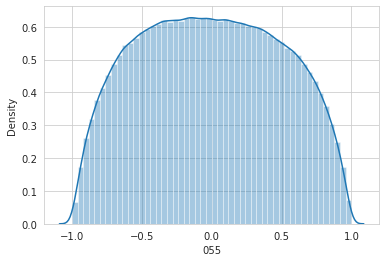

In [47]:
sns.distplot(alphas[f'{alpha:03}']);

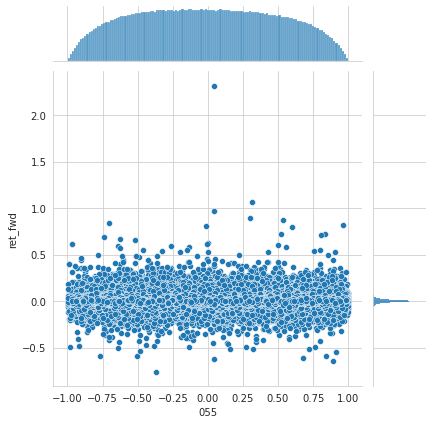

In [48]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [49]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 056

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [50]:
def alpha056(r, cap):
    """-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
    """
    pass

## Alpha 057

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [51]:
def alpha057(c, vwap):
    """-(close - vwap) / ts_weighted_mean(rank(ts_argmax(close, 30)), 2)"""
    return (c.sub(vwap.add(1e-5))
            .div(ts_weighted_mean(rank(ts_argmax(c, 30)))).mul(-1)
            .stack('code')
            .swaplevel())

In [52]:
alpha = 57

In [53]:
%%time
alphas[f'{alpha:03}'] = alpha057(c, vwap)

CPU times: user 1min 54s, sys: 280 ms, total: 1min 54s
Wall time: 1min 53s


In [54]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

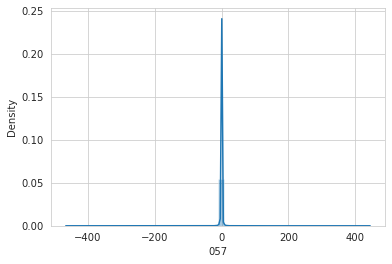

In [55]:
sns.distplot(alphas[f'{alpha:03}']);

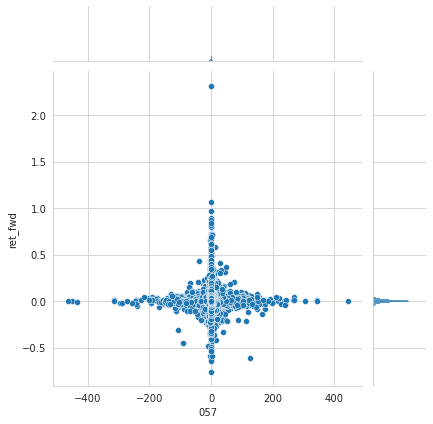

In [56]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [57]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.006408315924969266

## Alpha 058

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [58]:
def alpha58(v, wvap, sector):
    """(-1 * ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.sector), volume, 3), 7), 5))"""
    pass

## Alpha 059

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [59]:
def alpha59(v, wvap, industry):
    """-ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), volume, 4), 16), 8)"""
    pass

## Alpha 060

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [60]:
def alpha060(l, h, c, v):
    """-((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10))))"""
    return (scale(rank(c.mul(2).sub(l).sub(h)
                       .div(h.sub(l).replace(0, 1e-5))
                       .mul(v))).mul(2)
            .sub(scale(rank(ts_argmax(c, 10)))).mul(-1)
            .stack('code')
            .swaplevel())

In [61]:
alpha = 60

In [62]:
%%time
alphas[f'{alpha:03}'] = alpha060(l, h, c, v)

CPU times: user 1min 57s, sys: 372 ms, total: 1min 57s
Wall time: 1min 56s


In [63]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

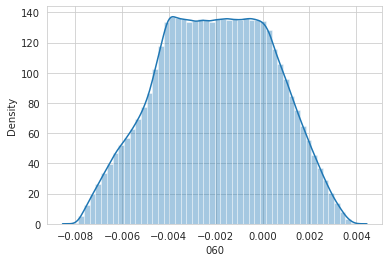

In [64]:
sns.distplot(alphas[f'{alpha:03}']);

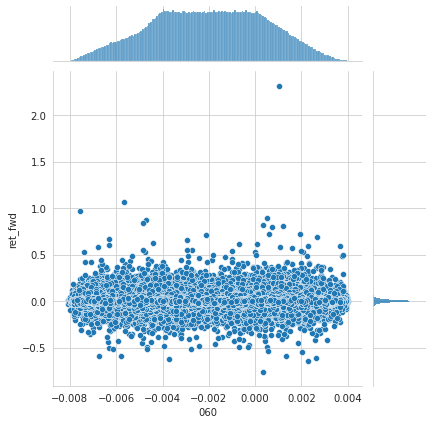

In [65]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [66]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 061

```
(rank((vwap - ts_min(vwap, 16.1219))) < rank(ts_corr(vwap, adv180, 17.9282)))
```

In [67]:
def alpha061(v, vwap):
    """rank((vwap - ts_min(vwap, 16))) < rank(ts_corr(vwap, adv180, 17))"""

    return (rank(vwap.sub(ts_min(vwap, 16)))
            .lt(rank(ts_corr(vwap, ts_mean(v, 180), 18)))
            .astype(int)
            .stack('code')
            .swaplevel())

In [68]:
alpha = 61

In [69]:
%%time
alphas[f'{alpha:03}'] = alpha061(v, vwap)

CPU times: user 4.58 s, sys: 112 ms, total: 4.69 s
Wall time: 4.64 s


In [70]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

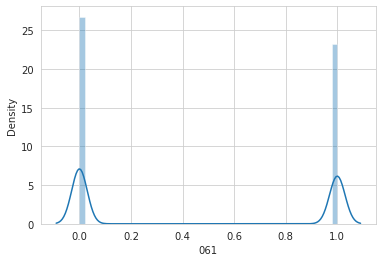

In [71]:
sns.distplot(alphas[f'{alpha:03}']);

In [72]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
061                                                                         
0    671704.0  0.000458  0.025757 -0.757755 -0.009681  0.000413  0.010529   
1    583389.0  0.000724  0.025759 -0.643066 -0.009615  0.000599  0.010819   

          max  
061            
0    2.317073  
1    0.972222

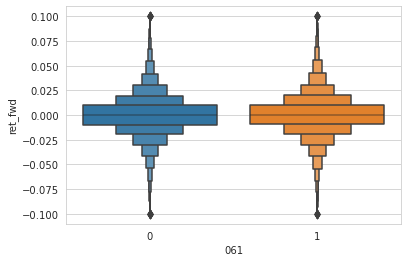

In [73]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.1, .1)]);

## Alpha 062

```
((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
```

In [74]:
def alpha062(o, h, l, vwap, adv20):
    """((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) < 
    rank(((rank(open) + rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)"""
    return (rank(ts_corr(vwap, ts_sum(adv20, 22), 9))
            .lt(rank(
                rank(o).mul(2))
                .lt(rank(h.add(l).div(2))
                    .add(rank(h))))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [75]:
alpha = 62

In [76]:
%%time
alphas[f'{alpha:03}'] = alpha062(o, h, l, vwap, adv20)

CPU times: user 3.67 s, sys: 36.3 ms, total: 3.71 s
Wall time: 3.64 s


In [77]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

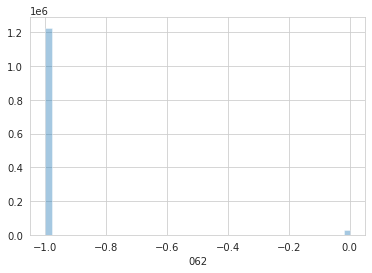

In [78]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

In [79]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
062                                                                          
-1   1227397.0  0.000582  0.025877 -0.757755 -0.009697  0.000496  0.010711   
 0     27696.0  0.000545  0.019795 -0.441048 -0.007788  0.000648  0.008919   

          max  
062            
-1   2.317073  
 0   0.436170

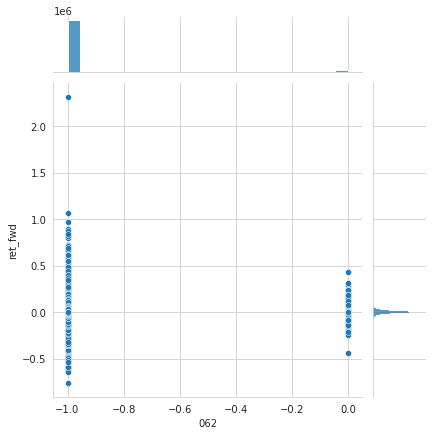

In [80]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [81]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 063

```
((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))), ts_sum(adv180,37.2467), 13.557), 12.2883))) * -1)
```

In [82]:
def alpha63(v, wvap, industry):
    """((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2), 8)) - 
        rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))), 
                                        ts_sum(adv180, 37), 13), 12))) * -1)
    """
    pass

In [83]:
alpha = 63

In [84]:
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)

In [85]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [86]:
# sns.distplot(alphas[f'{alpha:03}']);

In [87]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [88]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 064

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [89]:
def alpha064(o, h, l, v, vwap):
    """((rank(ts_corr(ts_sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054),ts_sum(adv120, 12.7054), 16.6208)) <
        rank(ts_delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1)"""
    w = 0.178404
    return (rank(ts_corr(ts_sum(o.mul(w).add(l.mul(1 - w)), 12),
                         ts_sum(ts_mean(v, 120), 12), 16))
            .lt(rank(ts_delta(h.add(l).div(2).mul(w)
                               .add(vwap.mul(1 - w)), 3)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [90]:
alpha = 64

In [91]:
%%time
alphas[f'{alpha:03}'] = alpha064(o, h, l, v, vwap)

CPU times: user 3.74 s, sys: 40.3 ms, total: 3.79 s
Wall time: 3.69 s


In [92]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [93]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
064                                                                         
-1   590330.0  0.000463  0.025842 -0.757755 -0.009714  0.000410  0.010584   
 0   664763.0  0.000687  0.025683 -0.619752 -0.009595  0.000576  0.010741   

          max  
064            
-1   2.317073  
 0   0.869835

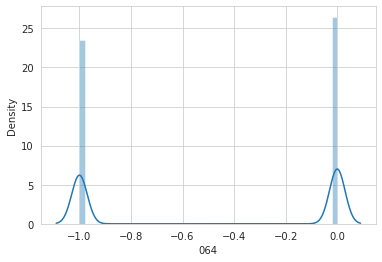

In [94]:
sns.distplot(alphas[f'{alpha:03}']);

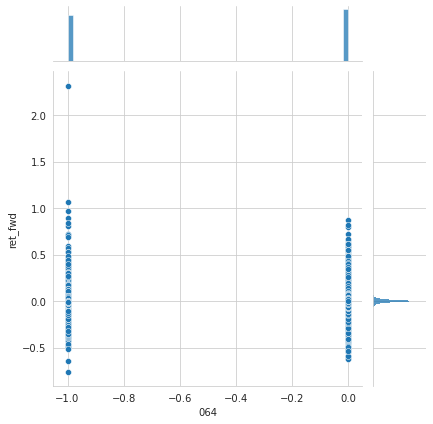

In [95]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 065

```
((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), 
                        ts_sum(adv60,8.6911), 6.40374)) < 
        rank((open - ts_min(open, 13.635)))) * -1)
```

In [96]:
def alpha065(o, v, vwap):
    """((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), 
                        ts_sum(adv60,8.6911), 6.40374)) < 
        rank((open - ts_min(open, 13.635)))) * -1)
    """
    w = 0.00817205
    return (rank(ts_corr(o.mul(w).add(vwap.mul(1 - w)),
                         ts_mean(ts_mean(v, 60), 9), 6))
            .lt(rank(o.sub(ts_min(o, 13))))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [97]:
alpha = 65

In [98]:
%%time
alphas[f'{alpha:03}'] = alpha065(o, v, vwap)

CPU times: user 3.83 s, sys: 32 ms, total: 3.86 s
Wall time: 3.79 s


In [99]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

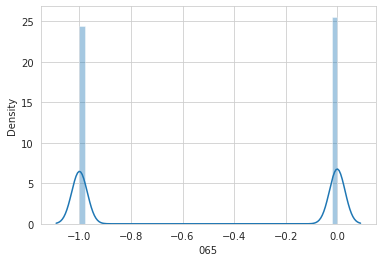

In [100]:
sns.distplot(alphas[f'{alpha:03}']);

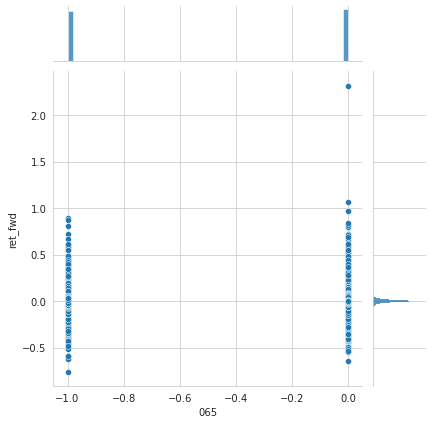

In [101]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 066

```
((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) + 
        ts_rank(ts_weighted_mean(((((low* 0.96633) + (low * 
                                    (1 - 0.96633))) - vwap) / 
                                    (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
```

In [102]:
def alpha066(l, h, vwap):
    """((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) +
        ts_rank(ts_weighted_mean(((((low* 0.96633) + (low *
                                    (1 - 0.96633))) - vwap) /
                                    (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
    """
    w = 0.96633
    return (rank(ts_weighted_mean(ts_delta(vwap, 4), 7))
            .add(ts_rank(ts_weighted_mean(l.mul(w).add(l.mul(1 - w))
                                           .sub(vwap)
                                           .div(o.sub(h.add(l).div(2)).add(1e-3)), 11), 7))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [103]:
alpha = 66

In [104]:
%%time
alphas[f'{alpha:03}'] = alpha066(l, h, vwap)

CPU times: user 3min, sys: 257 ms, total: 3min
Wall time: 3min


In [105]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

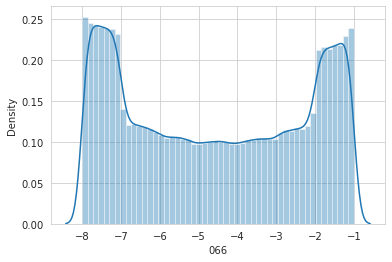

In [106]:
sns.distplot(alphas[f'{alpha:03}']);

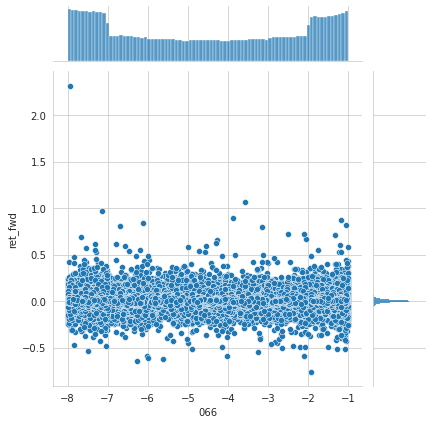

In [107]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [108]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.009140875589292108

## Alpha 067

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [109]:
def alpha067(h, v, sector, subindustry):
    """(power(rank((high - ts_min(high, 2.14593))),
        rank(ts_corr(IndNeutralize(vwap,IndClass.sector), 
                IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
    """
    pass

In [110]:
alpha = 67

In [111]:
# %%time
# alphas[f'{alpha:03}'] = alpha056(r, cap)

In [112]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [113]:
# sns.distplot(alphas[f'{alpha:03}']);

In [114]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [115]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 068

```
((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) <
        rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
```

In [116]:
def alpha068(h, c, v):
    """((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) <
        rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
    """
    w = 0.518371
    return (ts_rank(ts_corr(rank(h), rank(ts_mean(v, 15)), 9), 14)
            .lt(rank(ts_delta(c.mul(w).add(l.mul(1 - w)), 1)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [117]:
alpha = 68

In [118]:
%%time
alphas[f'{alpha:03}'] = alpha068(h, c, v)

CPU times: user 2min 54s, sys: 66.2 ms, total: 2min 54s
Wall time: 2min 54s


In [119]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

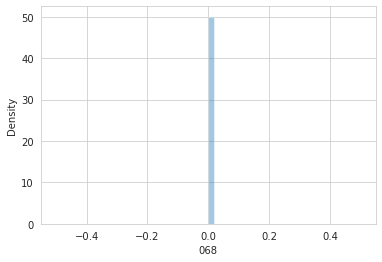

In [120]:
sns.distplot(alphas[f'{alpha:03}']);

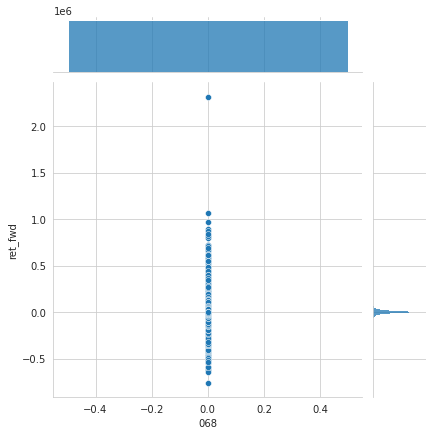

In [121]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 069

```
((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)),
        Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1)
```

In [122]:
def alpha069(c, vwap, industry):
    """((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)),
    Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1)
    """
    pass

## Alpha 070

```
((power(rank(ts_delta(vwap, 1.29456)),
        ts_rank(ts_corr(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171))) * -1)
```

In [123]:
def alpha076(c, v, vwap, industry):
    """((power(rank(ts_delta(vwap, 1.29456)),
        ts_rank(ts_corr(IndNeutralize(close, IndClass.industry), adv50, 17.8256), 17.9171))) * -1)
    """
    pass

In [124]:
alpha = 70

## Alpha 071

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [125]:
def alpha071(o, c, v, vwap):
    """max(ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 3.43976), ts_rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), 
            ts_rank(ts_weighted_mean((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388))"""

    s1 = (ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 3),
                                           ts_rank(ts_mean(v, 180), 12), 18), 4), 16))
    s2 = (ts_rank(ts_weighted_mean(rank(l.add(o).
                                        sub(vwap.mul(2)))
                                   .pow(2), 16), 4))
    return (s1.where(s1 > s2, s2)
            .stack('code')
            .swaplevel())

In [126]:
alpha = 71

In [127]:
%%time
alphas[f'{alpha:03}'] = alpha071(o, c, v, vwap)

CPU times: user 9min 28s, sys: 81.3 ms, total: 9min 29s
Wall time: 9min 28s


In [128]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

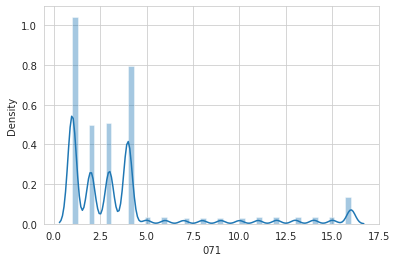

In [129]:
sns.distplot(alphas[f'{alpha:03}']);

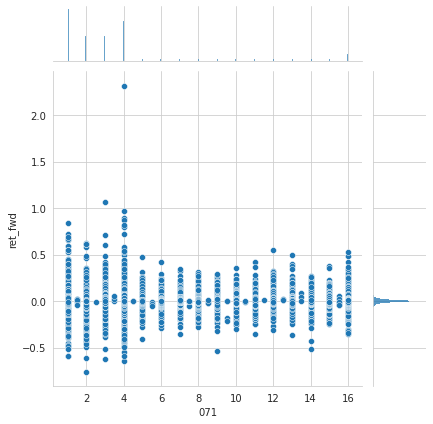

In [130]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [131]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.002330970321091197

## Alpha 072

```
(rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) /
        rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
```

In [132]:
def alpha072(h, l, v, vwap):
    """(rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) /
        rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
    """
    return (rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 9), 10))
            .div(rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3), ts_rank(v, 18), 6), 2)))
            .stack('code')
            .swaplevel())

In [133]:
alpha = 72

In [134]:
%%time
alphas[f'{alpha:03}'] = alpha072(h, l, v, vwap)

CPU times: user 6min 5s, sys: 95.2 ms, total: 6min 5s
Wall time: 6min 4s


In [135]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

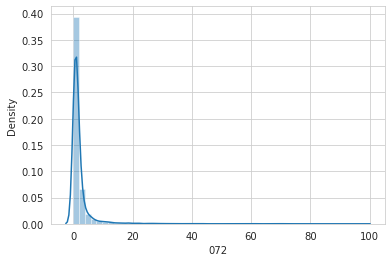

In [136]:
sns.distplot(alphas[f'{alpha:03}']);

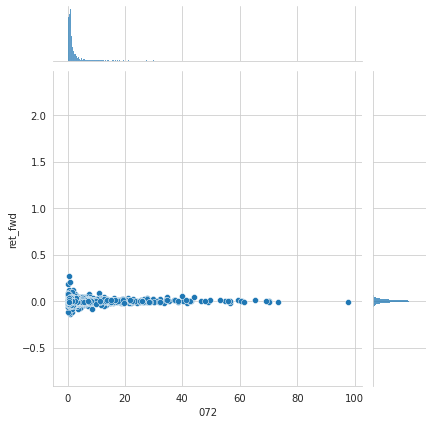

In [137]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 073

```
(max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)),
        ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) + 
            (low * (1 - 0.147155))), 2.03608) / 
            ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
```

In [138]:
def alpha073(l, vwap):
    """(max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)),
        ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) + 
            (low * (1 - 0.147155))), 2.03608) / 
            ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
        """
    w = 0.147155
    s1 = rank(ts_weighted_mean(ts_delta(vwap, 5), 3))
    s2 = (ts_rank(ts_weighted_mean(ts_delta(o.mul(w).add(l.mul(1 - w)), 2)
                                   .div(o.mul(w).add(l.mul(1 - w)).mul(-1)), 3), 16))

    print(s2)
    return (s1.where(s1 > s2, s2)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [139]:
alpha = 73

In [140]:
# %%time
alphas[f'{alpha:03}'] = alpha073(l, vwap)

ticker         A   AAL   AAP  AAPL   ABC  ABT   ACN  ADBE   ADI   ADM  ...  \
date                                                                   ...   
2007-01-04   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-05   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-08   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-09   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-10   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...  ...   
2016-12-22   8.0   5.0  11.0  12.0   9.0  7.0  16.0  10.0   6.0  14.0  ...   
2016-12-23  10.0  14.0  15.0  14.0  12.0  6.0  15.0  12.0   8.0  15.0  ...   
2016-12-27   7.0  16.0  13.0  13.0  10.0  5.0  12.0  11.0   7.0  13.0  ...   
2016-12-28  11.0  16.0  10.0  11.0   7.0  6.0  12.0  14.0   7.0  11.0  ...   
2016-12-29  14.0  16.0  10.0  12.0   6.0  9.0  12.0  14.0  13.0 

In [141]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

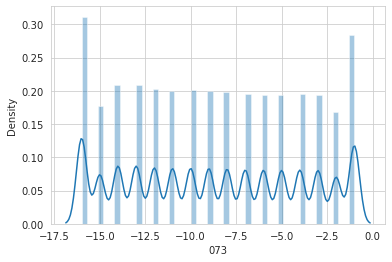

In [142]:
sns.distplot(alphas[f'{alpha:03}']);

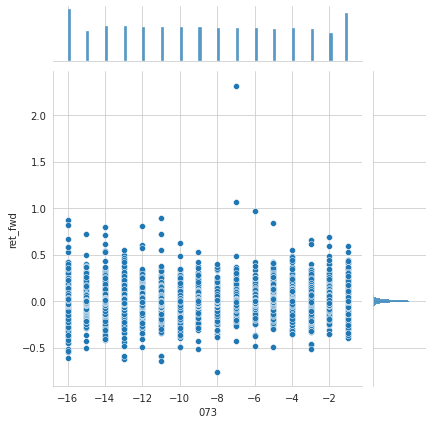

In [143]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [144]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0019621236363676076

## Alpha 074

```
((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) <
        rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
```

In [145]:
def alpha074(v, vwap):
    """((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) <
        rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)"""

    w = 0.0261661
    return (rank(ts_corr(c, ts_mean(ts_mean(v, 30), 37), 15))
            .lt(rank(ts_corr(rank(h.mul(w).add(vwap.mul(1 - w))), rank(v), 11)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [146]:
alpha = 74

In [147]:
%%time
alphas[f'{alpha:03}'] = alpha074(v, vwap)

CPU times: user 4.76 s, sys: 64 ms, total: 4.82 s
Wall time: 4.73 s


In [148]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

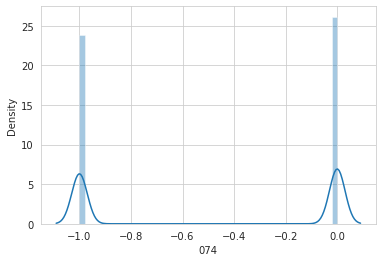

In [149]:
sns.distplot(alphas[f'{alpha:03}']);

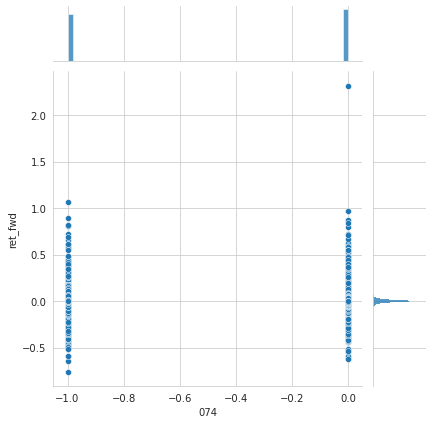

In [150]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [151]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
074                                                                         
-1   598745.0  0.000563  0.026009 -0.757755 -0.009807  0.000456  0.010752   
 0   656348.0  0.000599  0.025527 -0.619752 -0.009509  0.000538  0.010582   

          max  
074            
-1   1.061026  
 0   2.317073

## Alpha 075

```
(rank(ts_corr(vwap, volume, 4.24304)) < 
        rank(ts_corr(rank(low), rank(adv50),12.4413)))
```

In [152]:
def alpha075(l, v, vwap):
    """(rank(ts_corr(vwap, volume, 4.24304)) < 
        rank(ts_corr(rank(low), rank(adv50),12.4413)))
    """

    return (rank(ts_corr(vwap, v, 4))
            .lt(rank(ts_corr(rank(l), rank(ts_mean(v, 50)), 12)))
            .astype(int)
            .stack('code')
            .swaplevel())

In [153]:
alpha = 75

In [154]:
%%time
alphas[f'{alpha:03}'] = alpha075(l, v, vwap)

CPU times: user 4.79 s, sys: 36 ms, total: 4.83 s
Wall time: 4.76 s


In [155]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

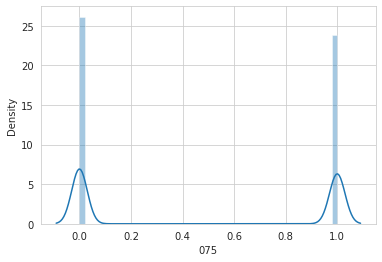

In [156]:
sns.distplot(alphas[f'{alpha:03}']);

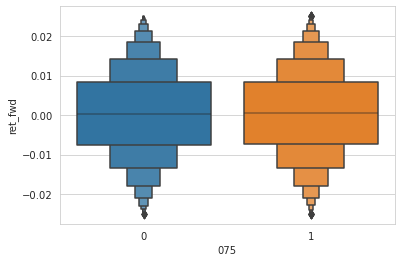

In [157]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [158]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
075                                                                         
0    656508.0  0.000545  0.026144 -0.757755 -0.009674  0.000472  0.010631   
1    598585.0  0.000621  0.025328 -0.607908 -0.009625  0.000529  0.010706   

          max  
075            
0    2.317073  
1    0.814423

## Alpha 076

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [159]:
def alpha076(l, vwap, sector):
    """(max(rank(ts_weighted_mean(ts_delta(vwap, 1.24383), 11.8259)),
            ts_rank(ts_weighted_mean(ts_rank(ts_corr(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1)
    """
    pass

In [160]:
alpha = 76

## Alpha 077

```
min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),
            rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125)))
```

In [161]:
def alpha077(l, h, vwap):
    """min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),
            rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125)))
    """

    s1 = rank(ts_weighted_mean(h.add(l).div(2).sub(vwap), 20))
    s2 = rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 3), 5))
    return (s1.where(s1 < s2, s2)
            .stack('code')
            .swaplevel())

In [162]:
alpha = 77

In [163]:
%%time
alphas[f'{alpha:03}'] = alpha077(l, h, vwap)

CPU times: user 3.73 s, sys: 16 ms, total: 3.75 s
Wall time: 3.66 s


In [164]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

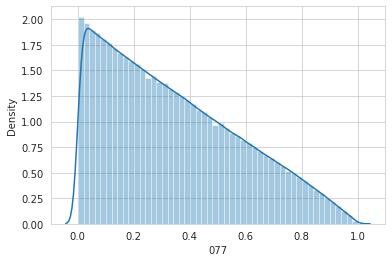

In [165]:
sns.distplot(alphas[f'{alpha:03}']);

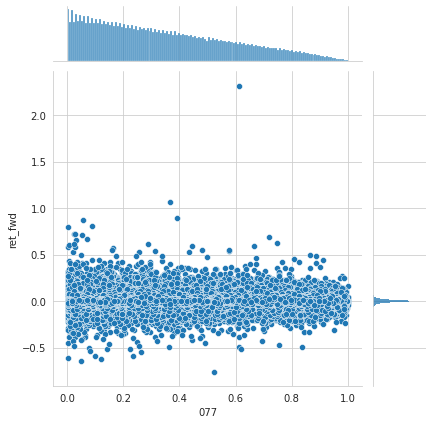

In [166]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [167]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 078

```
(rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),
        ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492)))
```

In [168]:
def alpha078(l, v, vwap):
    """(rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),
        ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492)))"""

    w = 0.352233
    return (rank(ts_corr(ts_sum((l.mul(w).add(vwap.mul(1 - w))), 19),
                         ts_sum(ts_mean(v, 40), 19), 6))
            .pow(rank(ts_corr(rank(vwap), rank(v), 5)))
            .stack('code')
            .swaplevel())

In [169]:
alpha = 78

In [170]:
%%time
alphas[f'{alpha:03}'] = alpha078(l, v, vwap)

CPU times: user 4.67 s, sys: 20 ms, total: 4.69 s
Wall time: 4.59 s


In [171]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

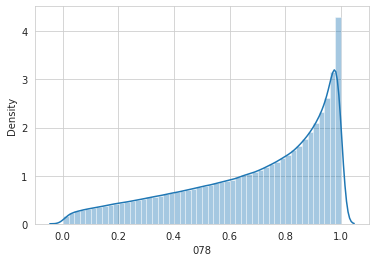

In [172]:
sns.distplot(alphas[f'{alpha:03}']);

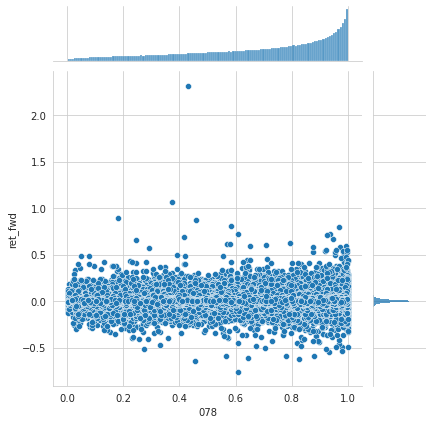

In [173]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [174]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0002397436931129704

## Alpha 079

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [175]:
def alpha079(o, v, sector):
    """(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
    """
    pass

## Alpha 080

```
((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))),
        ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1)
```

In [176]:
def alpha080(h, industry):
    """((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))),
        ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1)
    """
    pass

## Alpha 081

```
-(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) <
        rank(ts_corr(rank(vwap), rank(volume), 5.07914)))
```

In [177]:
def alpha081(v, vwap):
    """-(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) <
        rank(ts_corr(rank(vwap), rank(volume), 5.07914)))"""

    return (rank(log(ts_product(rank(rank(ts_corr(vwap,
                                                  ts_sum(ts_mean(v, 10), 50), 8))
                                     .pow(4)), 15)))
            .lt(rank(ts_corr(rank(vwap), rank(v), 5)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [178]:
alpha = 81

In [179]:
%%time
alphas[f'{alpha:03}'] = alpha081(v, vwap)

CPU times: user 1min 57s, sys: 593 ms, total: 1min 57s
Wall time: 1min 57s


In [180]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

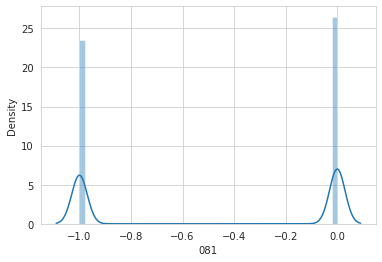

In [181]:
sns.distplot(alphas[f'{alpha:03}']);

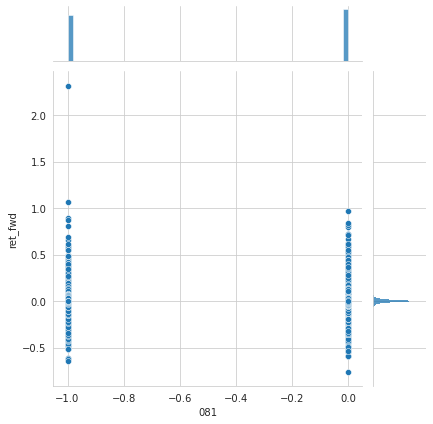

In [182]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [183]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 082

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [184]:
def alpha082(o, v, sector):
    """(min(rank(ts_weighted_mean(ts_delta(open, 1.46063), 14.8717)),
        ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(volume, IndClass.sector), 
        ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)
    
    """
    pass

## Alpha 083

```
(rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) / 
    (((high - low) / ts_mean(close, 5) / (vwap - close)))
```

In [185]:
def alpha083(h, l, c):
    """(rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) / 
            (((high - low) / ts_mean(close, 5) / (vwap - close)))
    """
    s = h.sub(l).div(ts_mean(c, 5))

    return (rank(rank(ts_lag(s, 2))
                 .mul(rank(rank(v)))
                 .div(s).div(vwap.sub(c).add(1e-3)))
            .stack('code')
            .swaplevel()
            .replace((np.inf, -np.inf), np.nan))

In [186]:
alpha = 83

In [187]:
%%time
alphas[f'{alpha:03}'] = alpha083(h, l, c)

CPU times: user 2.8 s, sys: 16 ms, total: 2.81 s
Wall time: 2.75 s


In [188]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

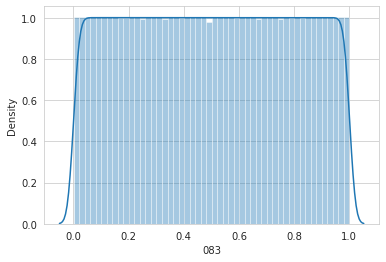

In [189]:
sns.distplot(alphas[f'{alpha:03}']);

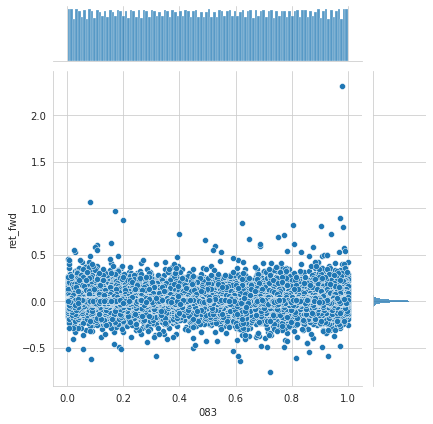

In [190]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [191]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0005100117425032025

## Alpha 084

```
power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), 
            ts_delta(close,4.96796))
```

In [192]:
def alpha084(c, vwap):
    """power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), 
        ts_delta(close,4.96796))"""
    return (rank(power(ts_rank(vwap.sub(ts_max(vwap, 15)), 20),
                       ts_delta(c, 6)))
            .stack('code')
            .swaplevel())

In [193]:
alpha = 84

In [194]:
%%time
alphas[f'{alpha:03}'] = alpha084(c, vwap)

CPU times: user 3min 2s, sys: 47.7 ms, total: 3min 2s
Wall time: 3min 2s


In [195]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

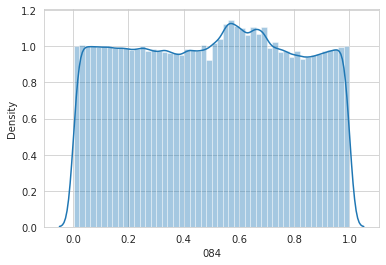

In [196]:
sns.distplot(alphas[f'{alpha:03}']);

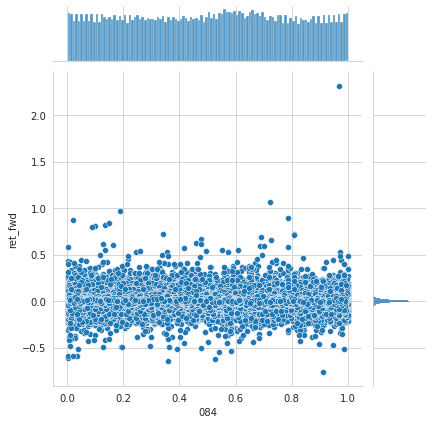

In [197]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [198]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.008688359695486092

## Alpha 085

```
power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)),
        rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), 
                     ts_rank(volume, 10.1595),7.11408)))
```

In [199]:
def alpha085(l, v):
    """power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)),
        rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), 
                     ts_rank(volume, 10.1595),7.11408)))
                     """
    w = 0.876703
    return (rank(ts_corr(h.mul(w).add(c.mul(1 - w)), ts_mean(v, 30), 10))
            .pow(rank(ts_corr(ts_rank(h.add(l).div(2), 4),
                              ts_rank(v, 10), 7)))
            .stack('code')
            .swaplevel())

In [200]:
alpha = 85

In [201]:
%%time
alphas[f'{alpha:03}'] = alpha085(l, v)

CPU times: user 6min 14s, sys: 123 ms, total: 6min 14s
Wall time: 6min 14s


In [202]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

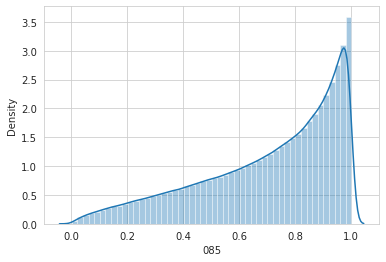

In [203]:
sns.distplot(alphas[f'{alpha:03}']);

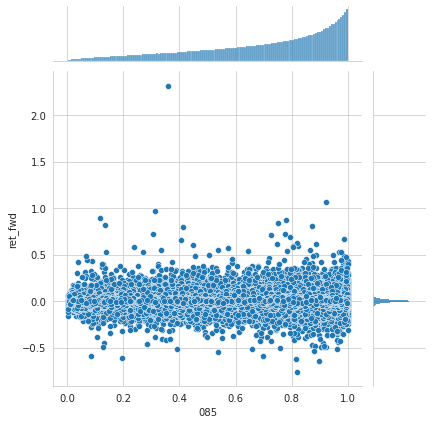

In [204]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [205]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.001101338196749957

## Alpha 086

```
((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) < 
        rank(((open + close) - (vwap + open)))) * -1)
```

In [206]:
def alpha086(c, v, vwap):
    """((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) < 
        rank(((open + close) - (vwap + open)))) * -1)
    """
    return (ts_rank(ts_corr(c, ts_mean(ts_mean(v, 20), 15), 6), 20)
            .lt(rank(c.sub(vwap)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [207]:
alpha = 86

In [208]:
%%time
alphas[f'{alpha:03}'] = alpha086(c, v, vwap)

CPU times: user 3min 2s, sys: 152 ms, total: 3min 2s
Wall time: 3min 2s


In [209]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

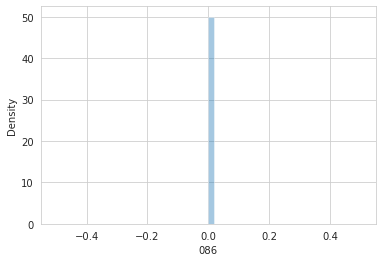

In [210]:
sns.distplot(alphas[f'{alpha:03}']);

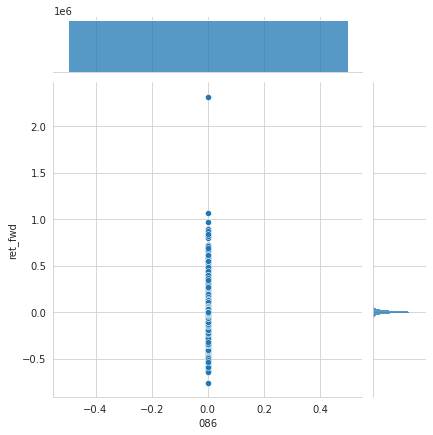

In [211]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [212]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.00020642450841457105

## Alpha 087

```
(max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), 
            ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
            ```

In [213]:
def alpha087(c, vwap, industry):
    """(max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), 
            ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
    """
    pass

## Alpha 088

```
min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), 
        ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728), 
                ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
```

In [214]:
def alpha088(o, h, l, c, v):
    """min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), 
        ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728), 
                ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))"""

    s1 = (rank(ts_weighted_mean(rank(o)
                                .add(rank(l))
                                .sub(rank(h))
                                .add(rank(c)), 8)))
    s2 = ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 8),
                                          ts_rank(ts_mean(v, 60), 20), 8), 6), 2)

    return (s1.where(s1 < s2, s2)
            .stack('code')
            .swaplevel())

In [215]:
alpha = 88

In [216]:
%%time
alphas[f'{alpha:03}'] = alpha088(o, h, l, c, v)

CPU times: user 6min 7s, sys: 79.6 ms, total: 6min 7s
Wall time: 6min 7s


In [217]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

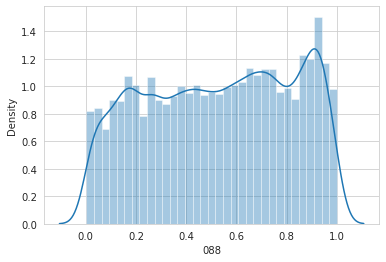

In [218]:
sns.distplot(alphas[f'{alpha:03}']);

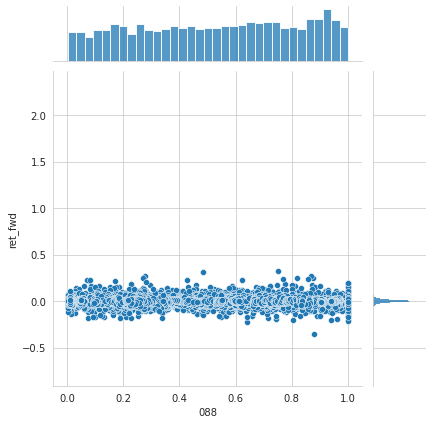

In [219]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [220]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'], n=30000)
mi[alpha]

0.019146991360432075

## Alpha 089

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [221]:
def alpha089(l, v, vwap, industry):
    """(ts_rank(ts_weighted_mean(ts_corr(((low * 0.967285) + 
        (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - 
        ts_rank(ts_weighted_mean(ts_delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
    """
    pass

## Alpha 090

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [222]:
def alpha090(c, l, subindustry):
    """((rank((close - ts_max(close, 4.66719)))
        ^ts_rank(ts_corr(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1)
    """
    pass

## Alpha 091

```
((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -
        rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1)
```

In [223]:
def alpha091(v, vwap, industry):
    """((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -
        rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1)
    """
    pass

## Alpha 092

```
min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), 
            ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
```

In [224]:
def alpha092(o, l, c, v):
    """min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), 
            ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
    """
    p1 = ts_rank(ts_weighted_mean(h.add(l).div(2).add(c).lt(l.add(o)), 15), 18)
    p2 = ts_rank(ts_weighted_mean(ts_corr(rank(l), rank(ts_mean(v, 30)), 7), 6), 6)

    return (p1.where(p1<p2, p2)
            .stack('code')
            .swaplevel())

In [225]:
alpha = 92

In [226]:
%%time
alphas[f'{alpha:03}'] = alpha092(o, l, c, v)

CPU times: user 4min 33s, sys: 39.8 ms, total: 4min 34s
Wall time: 4min 33s


In [227]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

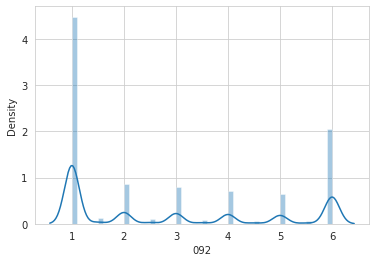

In [228]:
sns.distplot(alphas[f'{alpha:03}']);

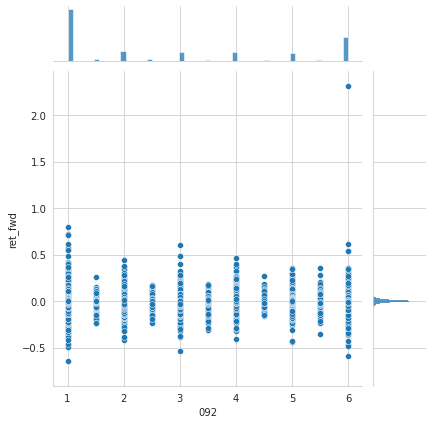

In [229]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [230]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0034230030791526644

## Alpha 093

```
(ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / 
        rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
```

In [231]:
def alpha093(c, v, vwap, industry):
    """(ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / 
        rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
    """
    pass

## Alpha 094

```
((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462), 
        ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
```

In [232]:
def alpha094(v, vwap):
    """((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462), 
        ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
    """

    return (rank(vwap.sub(ts_min(vwap, 11)))
            .pow(ts_rank(ts_corr(ts_rank(vwap, 20),
                                 ts_rank(ts_mean(v, 60), 4), 18), 2))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [233]:
alpha = 94

In [234]:
%%time
alphas[f'{alpha:03}'] = alpha094(v, vwap)

CPU times: user 8min 59s, sys: 164 ms, total: 8min 59s
Wall time: 9min


In [235]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

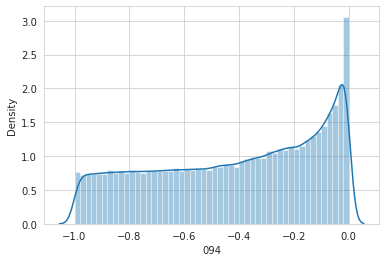

In [236]:
sns.distplot(alphas[f'{alpha:03}']);

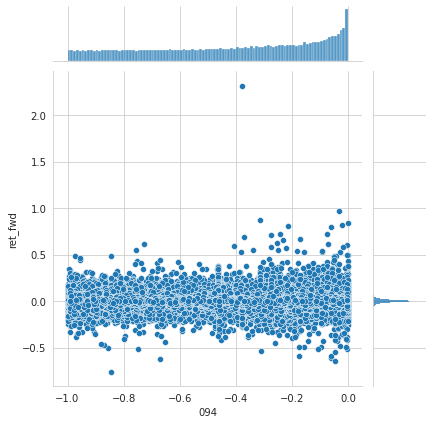

In [237]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [238]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.005173119205998944

## Alpha 095

```
(rank((open - ts_min(open, 12.4105))) < 
    ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), 
    ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584))
```

In [239]:
def alpha095(o, l, v):
    """(rank((open - ts_min(open, 12.4105))) < 
        ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584))
    """
    
    return (rank(o.sub(ts_min(o, 12)))
            .lt(ts_rank(rank(ts_corr(ts_mean(h.add(l).div(2), 19),
                                     ts_sum(ts_mean(v, 40), 19), 13).pow(5)), 12))
            .astype(int)
            .stack('code')
            .swaplevel())

In [240]:
alpha = 95

In [241]:
%%time
alphas[f'{alpha:03}'] = alpha095(o, l, v)

CPU times: user 3min 3s, sys: 43.9 ms, total: 3min 3s
Wall time: 3min 3s


In [242]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

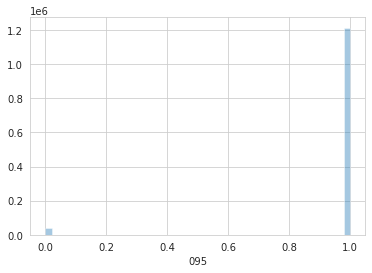

In [243]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

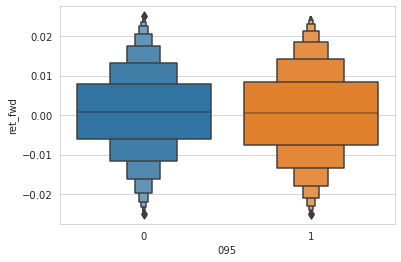

In [244]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [245]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
095                                                                          
0      42212.0  0.001107  0.018945 -0.441048 -0.006959  0.000900  0.008912   
1    1212881.0  0.000563  0.025963 -0.757755 -0.009764  0.000481  0.010736   

          max  
095            
0    0.500000  
1    2.317073

## Alpha 096

```
(max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151), 
        ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
```

In [246]:
def alpha096(c, v, vwap):
    """(max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151), 
        ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)"""
    
    s1 = ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(v), 10), 4), 8)
    s2 = ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(c, 7),
                                                    ts_rank(ts_mean(v, 60), 10), 10), 12), 14), 13)
    return (s1.where(s1 > s2, s2)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [247]:
alpha = 96

In [248]:
%%time
alphas[f'{alpha:03}'] = alpha096(c, v, vwap)

CPU times: user 10min 4s, sys: 432 ms, total: 10min 4s
Wall time: 10min 6s


In [249]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

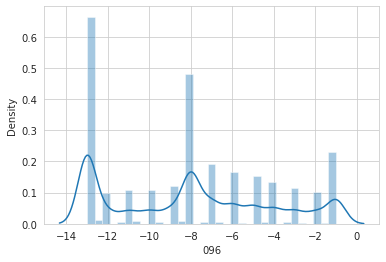

In [250]:
sns.distplot(alphas[f'{alpha:03}']);

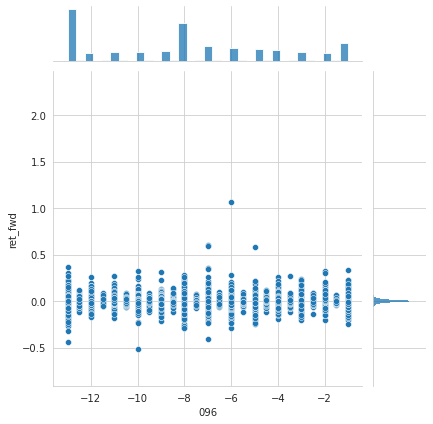

In [251]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)


## Alpha 097

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [253]:
def alpha097(l):
    """((rank(ts_weighted_mean(ts_delta(IndNeutralize(((low * 0.721001) + 
        (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) - 
        ts_rank(ts_weighted_mean(ts_rank(ts_corr(Ts_Rank(low,7.87871), 
        ts_rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1)
    """
    pass

## Alpha 098

```
(rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) -
        rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open), 
        rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
```

In [254]:
def alpha098(o, v, vwap):
    """(rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) -
        rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open), 
        rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
    """
    adv5 = ts_mean(v, 5)
    adv15 = ts_mean(v, 15)
    return (rank(ts_weighted_mean(ts_corr(vwap, ts_mean(adv5, 26), 4), 7))
            .sub(rank(ts_weighted_mean(ts_rank(ts_argmin(ts_corr(rank(o),
                                                                 rank(adv15), 20), 8), 6))))
            .stack('code')
            .swaplevel())

In [255]:
alpha = 98

In [256]:
%%time
alphas[f'{alpha:03}'] = alpha098(o, v, vwap)

CPU times: user 4min 54s, sys: 389 ms, total: 4min 54s
Wall time: 4min 54s


In [257]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

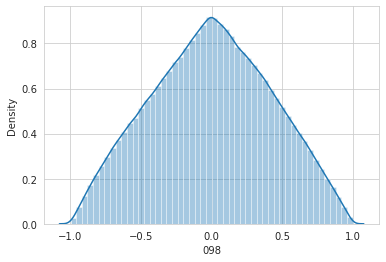

In [258]:
sns.distplot(alphas[f'{alpha:03}']);

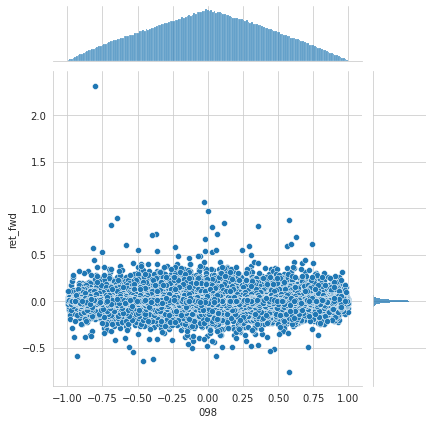

In [259]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [260]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 099

```
((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975), 
                    ts_sum(adv60, 19.8975), 8.8136)) <
                    rank(ts_corr(low, volume, 6.28259))) * -1)
```

In [261]:
def alpha099(l, v):
    """((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975), 
                    ts_sum(adv60, 19.8975), 8.8136)) <
                    rank(ts_corr(low, volume, 6.28259))) * -1)"""

    return ((rank(ts_corr(ts_sum((h.add(l).div(2)), 19),
                          ts_sum(ts_mean(v, 60), 19), 8))
             .lt(rank(ts_corr(l, v, 6)))
             .mul(-1))
            .stack('code')
            .swaplevel())

In [262]:
alpha = 99

In [263]:
%%time
alphas[f'{alpha:03}'] = alpha099(l, v)

CPU times: user 4.53 s, sys: 21 µs, total: 4.53 s
Wall time: 4.44 s


In [264]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

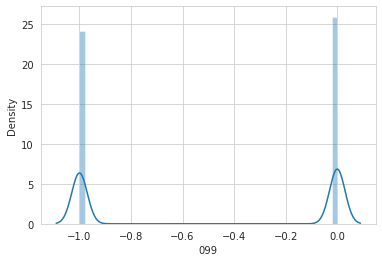

In [265]:
sns.distplot(alphas[f'{alpha:03}']);

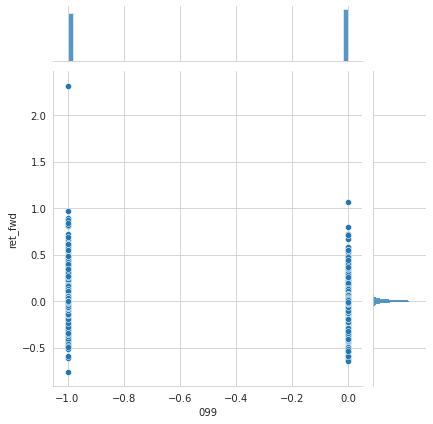

In [266]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [267]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
099                                                                         
-1   604583.0  0.000537  0.026239 -0.757755 -0.009783  0.000448  0.010714   
 0   650510.0  0.000622  0.025303 -0.643066 -0.009524  0.000547  0.010625   

          max  
099            
-1   2.317073  
 0   1.061026

## Alpha 100

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [268]:
def alpha100(r, cap):
    """(0 - (1 * (((1.5 * scale(indneutralize(
                indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), 
                                IndClass.subindustry), IndClass.subindustry))) - 
    scale(indneutralize((ts_corr(close, rank(adv20), 5) - rank(ts_argmin(close, 30))), IndClass.subindustry))) * (volume / adv20))))
    """
    pass

## Alpha 101

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [269]:
def alpha101(o, h, l, c):
    """((close - open) / ((high - low) + .001))"""
    return (c.sub(o).div(h.sub(l).add(1e-3))
            .stack('code')
            .swaplevel())

In [270]:
alpha = 101

In [271]:
%%time
alphas[f'{alpha:03}'] = alpha101(o, h, l, c)

CPU times: user 1.89 s, sys: 12 ms, total: 1.9 s
Wall time: 1.87 s


In [272]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

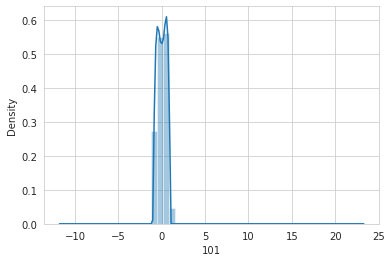

In [273]:
sns.distplot(alphas[f'{alpha:03}']);

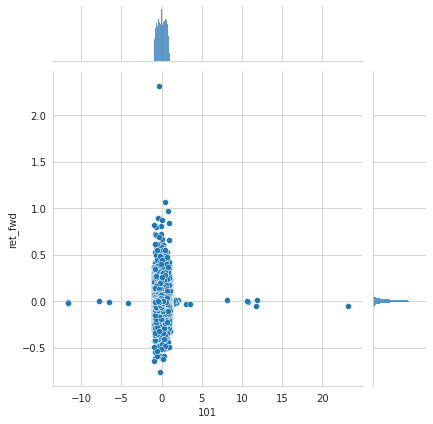

In [274]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [275]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0008757897861757513

## 存储结果

In [276]:
alphas = []
with pd.HDFStore('cn_alphas.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        i = int(key.split('/')[-1])
        alphas.append(store[key].to_frame(i))
alphas = pd.concat(alphas, axis=1)

In [277]:
alphas.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 82 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   1       1243849 non-null  float64
 1   2       1243080 non-null  float64
 2   3       1227126 non-null  float64
 3   4       1250757 non-null  float64
 4   5       1247733 non-null  float64
 5   6       1250204 non-null  float64
 6   7       1241633 non-null  float64
 7   8       1247172 non-null  float64
 8   9       1247548 non-null  float64
 9   10      1247548 non-null  float64
 10  11      1245756 non-null  float64
 11  12      1247548 non-null  float64
 12  13      1243849 non-null  float64
 13  14      1250204 non-null  float64
 14  15      1048657 non-null  float64
 15  16      1252899 non-null  float64
 16  17      1240819 non-null  float64
 17  18      1240862 non-null  float64
 18  19      1127248 non-null  flo

In [278]:
alphas.to_hdf('data.h5', 'factors/formulaic')